run with `popstrucure` env

In [1]:
import os
import vcf
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from matplotlib.pyplot import figure
import glob
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import statistics
import allel
from collections import defaultdict
from itertools import combinations
from haversine import haversine
from skbio.stats.distance import mantel
from scipy.stats import ttest_ind
import random
import time
import multiprocessing as mp
from matplotlib.colors import ListedColormap
from IPython.display import Image
from scipy.signal import medfilt
import cartopy.crs as ccrs
import cartopy.feature as cf
from pykrige.ok import OrdinaryKriging


Unable to determine R home: [Errno 20] Not a directory: 'R'
ERROR 1: PROJ: proj_create_from_database: Open of /master/nplatt/anaconda3/envs/popstructure/share/proj failed


In [2]:
proj_dir="/master/nplatt/sch_hae_scan"
results_dir="{}/results".format(proj_dir)

os.chdir(proj_dir)

In [3]:
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

# PCA

In [267]:
Path("{}/pca".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/pca".format(results_dir))

In [96]:
%%bash

#maf 05
conda run -n popstructure --cwd . --live-stream\
    vcftools \
        --vcf ../mapping_rates/mappable_snvs.vcf \
        --maf 0.05 \
        --chr NC_067196.1 \
        --chr NC_067197.1 \
        --chr NC_067198.1 \
        --chr NC_067199.1 \
        --chr NC_067200.1 \
        --chr NC_067201.1 \
        --chr NC_067202.1 \
        --recode \
        --recode-INFO-all \
        --stdout \
        >autosomes_maf05.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../mapping_rates/mappable_snvs.vcf
	--chr NC_067196.1
	--chr NC_067197.1
	--chr NC_067198.1
	--chr NC_067199.1
	--chr NC_067200.1
	--chr NC_067201.1
	--chr NC_067202.1
	--recode-INFO-all
	--maf 0.05
	--recode
	--stdout

After filtering, kept 171 out of 171 Individuals
Outputting VCF file...
After filtering, kept 5976612 out of a possible 35891773 Sites
Run Time = 3482.00 seconds


In [97]:
%%bash

#ld filtering
conda run -n popstructure --cwd . --live-stream\
    plink \
        --vcf autosomes_maf05.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out autosomes_maf05_ld_filtered

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to autosomes_maf05_ld_filtered.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out autosomes_maf05_ld_filtered
  --vcf autosomes_maf05.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.


Task exception was never retrieved
future: <Task finished name='Task-29' coro=<ScriptMagics.shebang.<locals>._handle_stream() done, defined at /master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/IPython/core/magics/script.py:211> exception=ValueError('Separator is not found, and chunk exceed the limit')>
Traceback (most recent call last):
  File "/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/asyncio/streams.py", line 540, in readline
    line = await self.readuntil(sep)
  File "/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/asyncio/streams.py", line 618, in readuntil
    raise exceptions.LimitOverrunError(
asyncio.exceptions.LimitOverrunError: Separator is not found, and chunk exceed the limit

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/IPython/core/magics/script.py", line 213, in _handle_stream
    line = (a

In [98]:
%%bash

conda run -n popstructure --cwd . --live-stream\
    vcftools \
        --vcf autosomes_maf05.vcf \
        --exclude autosomes_maf05_ld_filtered.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >autosomes_maf05_ld_filtered.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf autosomes_maf05.vcf
	--recode-INFO-all
	--recode
	--exclude autosomes_maf05_ld_filtered.prune.out
	--stdout

After filtering, kept 171 out of 171 Individuals
Outputting VCF file...
After filtering, kept 355715 out of a possible 5976612 Sites
Run Time = 202.00 seconds


Calculate PCA

In [ ]:
%%bash
conda run -n popstructure --cwd . --live-stream\
    plink \
        --vcf autosomes_maf05_ld_filtered.vcf \
        --pca \
        --double-id \
        --allow-extra-chr \
        --out pca

In [1]:
#get eigen values and sample labels
pca_df=pd.read_csv("pca.eigenvec", sep=" ", header=None)
pca_df.columns=["sample_name", "x"] + list(range(1, 21))
pca_df=pca_df.drop("x", axis=1)

# #now add sample info (including location data)
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#merge the dataframes
pca_df=pca_df.merge(info_df, how='left', on='sample_name')

#fix the country which contains some float NaNs
pca_df["country"] = pca_df["country"].astype(str)

countries = sorted(pca_df["country"].unique().astype(str))

NameError: name 'pd' is not defined

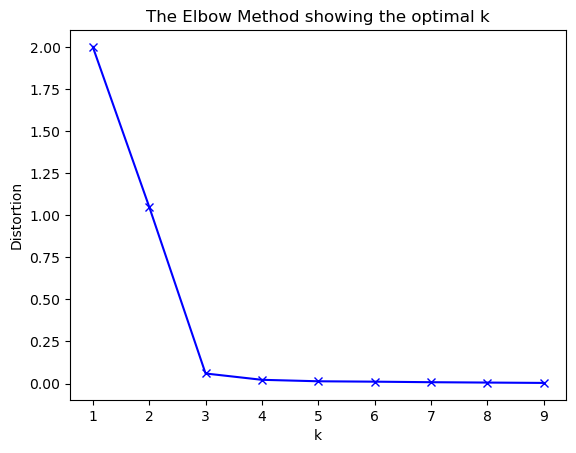

In [101]:
#code modified from https://predictivehacks.com/k-means-elbow-method-code-for-python/

#get pc1,pc2
pc1_pc2=pca_df.iloc[:,1:3].values.tolist()

distortions = []
K = range(1,10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto')
    kmeanModel.fit(pc1_pc2)
    distortions.append(kmeanModel.inertia_)
    
    
plt.figure()
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

plt.savefig("kmeans_elbow.png", dpi=300)
plt.savefig("kmeans_elbow.svg")

plt.show()

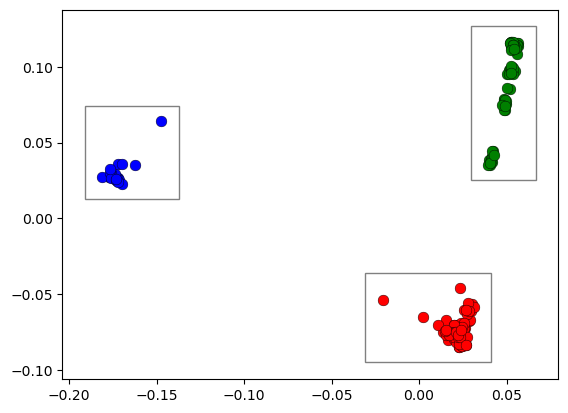

In [102]:
fig, ax = plt.subplots()

#visualize the three groups
kmeans=KMeans(n_clusters=3, random_state=0, n_init='auto').fit_predict(pc1_pc2)
pca_df["kmeans_group"]=kmeans

k_colors={0:"red", 1:"green", 2:"blue" }

for index, row in pca_df.iterrows():
    x=row[1]
    y=row[2]
    color=k_colors[kmeans[index]]
    plt.scatter(x, y, color=color, edgecolor="black", linewidths=0.3, s=60)
    

#add rectangles
for k in [0,1,2]:
    x1=pca_df[pca_df["kmeans_group"]==k][1].min()
    x2=pca_df[pca_df["kmeans_group"]==k][1].max()

    y1=pca_df[pca_df["kmeans_group"]==k][2].min()
    y2=pca_df[pca_df["kmeans_group"]==k][2].max()

    rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()



In [103]:
pca_species = {0: "s_haematobium",
               1: "s_haematobium",
               2: "s_bovis"}

In [104]:
pca_df["pca_species"] = str("Na")

for index, row in pca_df.iterrows():
    pca_df.at[index,"pca_species"] = pca_species[row["kmeans_group"]]

In [105]:
outgroups = {"guineensis_saotome_ERR119612": "s_guineensis",
             "intercalatum_drcongo_ERR119613": "s_intercalatum",
             "margrebowiei_zambia_ERR310940": "s_margrebowiei",
             "matthei_zambia_ERR103051": "s_matthei"}

for outgroup in outgroups.keys():
    pca_df.loc[pca_df["sample_name"] == outgroup, "pca_species"] = outgroups[outgroup]

In [106]:
pca_df.to_csv("pca_df.csv", index=False, sep=",", header=False, mode='w', na_rep='NaN')



pca_df


,sample_name,1,2,3,4,5,6,7,8,9,...,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species
0,Sb_NG_au_1.2,-0.173881,0.026648,0.002356,0.003491,0.040333,0.056209,0.034671,-0.018987,0.006714,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
1,Sb_NG_au_2.10,-0.173042,0.026219,0.002305,0.004889,0.041296,0.059342,0.034267,-0.018533,0.003969,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
2,Sb_NG_au_2.13,-0.173645,0.026263,0.002368,0.000767,0.042174,0.060543,0.032764,-0.020686,0.002916,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
3,Sb_NG_au_2.5,-0.172982,0.026137,0.003690,-0.002314,0.042092,0.059532,0.033454,-0.014835,0.000759,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
4,Sb_NG_au_2.6,-0.172250,0.026551,0.002041,0.004355,0.042407,0.059827,0.033576,-0.020790,0.009542,...,nigeria,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,niger,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium
169,ssp_niger_libore_173,0.026690,-0.083394,-0.003446,-0.070261,-0.010403,-0.085303,0.096133,-0.115088,0.082561,...,niger,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium


In [8]:
pca_df=pd.read_csv("pca_df.csv", sep=",", header=0)
pca_df


,sample_name,1,2,3,4,5,6,7,8,9,...,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,pca_species,kmeans_label
0,Sb_NG_au_1.2,-0.173881,0.026648,0.002356,0.003491,0.040333,0.056209,0.034671,-0.018987,0.006714,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
1,Sb_NG_au_2.10,-0.173042,0.026219,0.002305,0.004889,0.041296,0.059342,0.034267,-0.018533,0.003969,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
2,Sb_NG_au_2.13,-0.173645,0.026263,0.002368,0.000767,0.042174,0.060543,0.032764,-0.020686,0.002916,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
3,Sb_NG_au_2.5,-0.172982,0.026137,0.003690,-0.002314,0.042092,0.059532,0.033454,-0.014835,0.000759,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
4,Sb_NG_au_2.6,-0.172250,0.026551,0.002041,0.004355,0.042407,0.059827,0.033576,-0.020790,0.009542,...,na,cow,bovis,nigeria,genome,7.067448,6.271139,2,s_bovis,sb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,ssp_niger_libore_167,0.023576,-0.078099,-0.011150,-0.061000,0.017043,-0.045486,0.040388,-0.017674,0.024366,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
167,ssp_niger_libore_168,0.022321,-0.076938,-0.018901,-0.060000,0.006243,-0.004137,0.029055,-0.042276,0.080228,...,na,snail,unk,scan_africa,genome,13.390080,2.197110,0,s_haematobium,sh_nw
168,ssp_niger_libore_169,0.023969,-0.073719,-0.019718,-0.050199,0.016409,-0.015895,0.038597,-0.020768,0.037634,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw
169,ssp_niger_libore_173,0.026690,-0.083394,-0.003446,-0.070261,-0.010403,-0.085303,0.096133,-0.115088,0.082561,...,na,snail,unk,scan_africa,genome,13.404170,2.188020,0,s_haematobium,sh_nw


In [265]:
#set marker shapes based on PRESUMED species
markers = { 's_haematobium'  : "o", 
            's_sp'           : "v",
            's_bovis'        : "X",
            's_intercalatum' : "*", 
            's_guineensis'   : "P",
            's_margrebowiei' : "D", 
            's_matthei'      : "s",}

In [264]:
col_df=pd.read_csv(f"{proj_dir}/data/country_colors.csv", sep=",", header=0)
colors = col_df.set_index('country')['color'].to_dict()
colors


{'angola': '#FF0000',
 'swaziland': '#FF1C00',
 'ethiopia': '#FF3800',
 'kenya': '#FF5500',
 'madagascar': '#FF7100',
 'namibia': '#FF8D00',
 'tanzania': '#FFAA00',
 'uganda': '#FFC600',
 'zambia': '#FFE200',
 'zanzibar': '#FFFF00',
 'cameroon': '#0000FF',
 'cote_d_ivoire': '#0019E5',
 'egypt': '#0033CC',
 'gambia': '#004CB2',
 'guineabissau': '#006699',
 'liberia': '#007F7F',
 'mali': '#009965',
 'niger': '#00B24C',
 'nigeria': '#00CC32',
 'senegal': '#00E519',
 'sudan': '#00FF00',
 'na': '#808080'}

In [40]:
pca_df.loc[pca_df["kmeans_group"]==k]["1"].min()

-0.0207528

In [117]:
sum([float(val) for val in eigen_vals])


139.34214999999998

so based off this info I think that anything in group 0 or 1 (red or green) is a Sh and anything in blue is a Sb.
Update the df accordingly to indicate `pca_species`.

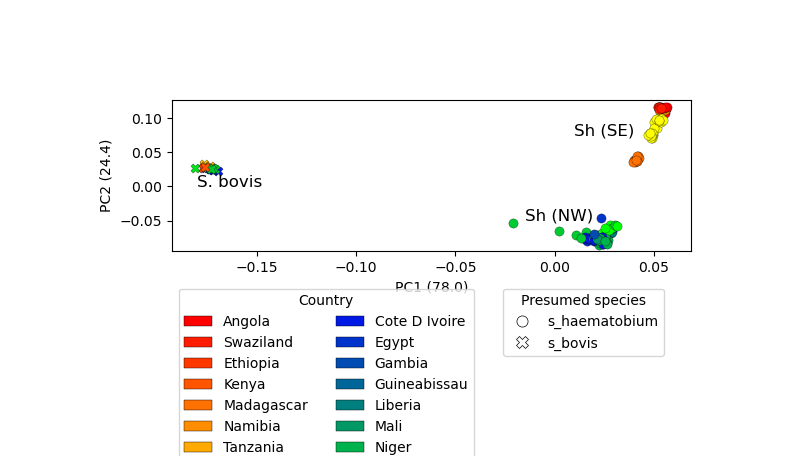

In [272]:
cm = 1/2.54 

#plot the results
#fig, ax = plt.subplots()
figure(figsize=(17*cm, 5*cm))

#figure(figsize=(6,6))
markers = { 's_haematobium'  : "o", 
            's_sp'           : "v",
            's_bovis'        : "X",
            's_intercalatum' : "*", 
            's_guineensis'   : "P",
            's_margrebowiei' : "D", 
            's_matthei'      : "s",}

pca_markers= { 's_haematobium'  : "o", 
               's_bovis'        : "X" }

pca_df = pca_df.sample(frac=1).reset_index(drop=True)
for index, row in pca_df.iterrows():
    if row["pca_species"] in ["s_haematobium", "s_bovis"]:
        x=row[1]
        y=row[2]
        marker=pca_markers[row["pca_species"]]
        color=colors[row["country"]]

        plt.scatter(x, y, marker=marker, color=color, edgecolor="black", linewidths=0.2, s=44)
    
# #set title
# num_snvs="^"
# plt.title("{} SNPs (MAF05, LD)".format(num_snvs))

#set x label (eigen 1)
eigen_vals=[line.strip() for line in open("pca.eigenval", 'r')]

pc1=eigen_vals[0]
plt.xlabel("PC1 ({:.1f})".format(float(pc1)))

#set x label (eigen 2)
pc2=eigen_vals[1]
plt.ylabel("PC2 ({:.1f})".format(float(pc2)))

# #add rectangles
# for k in [0,1,2]:
#     x1=pca_df[pca_df["kmeans_group"]==k]["1"].min()
#     x2=pca_df[pca_df["kmeans_group"]==k]["1"].max()

#     y1=pca_df[pca_df["kmeans_group"]==k]["2"].min()
#     y2=pca_df[pca_df["kmeans_group"]==k]["2"].max()

#     rect = mpatches.Rectangle((x1-.01, y1-.01), (x2-x1)+.02, (y2-y1)+.02, linewidth=1, edgecolor='grey', facecolor='none')
    
#     # Add the patch to the Axes
#     #ax.add_patch(rect)

#make legend for countries
country_patches=[]
for country in colors.keys():
    country_patch=mpatches.Patch(facecolor=colors[country], 
                         edgecolor="black", 
                         label=country.title().replace("_", " "),
                         linewidth=0.3)
    country_patches.append(country_patch)


prop={'size': 8}
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker], bbox_to_anchor=(1.05, 0.3))
#plt.legend(title="Presumed species", handles=[ssp_marker, ssh_marker, ssb_marker, sg_marker, si_marker, smar_marker, smat_marker], loc='lower right', prop={'size': 8}, edgecolor="black", fancybox=False, shadow=True)


#add kmeans group annotation
plt.annotate("Sh (SE)",   xy=( 0.010,   0.075), fontsize=12)
plt.annotate("Sh (NW)",   xy=(-0.015,  -0.05), fontsize=12)
plt.annotate("S. bovis",  xy=( -0.18,   0.00), fontsize=12)
#plt.annotate("Outgroups", xy=( -0.18,   0.075), fontsize=12)


# make legend for countries
country_legend = plt.legend(
    title="Country", 
    handles=[mpatches.Patch(facecolor=colors[country], edgecolor="black", label=country.title().replace("_", " "), linewidth=0.3) for country in colors.keys()],
    scatterpoints=1, 
    bbox_to_anchor=(0.0, -0.2), 
    loc='upper left', 
    ncol=2
)

# Create legend handles for species
species_handles = [
    mlines.Line2D([], [], color="white", markeredgecolor="black", markerfacecolor="white", marker=marker, markersize=8, markeredgewidth=0.5, label=species)
    for species, marker in pca_markers.items()
]

# make legend for species
species_legend = plt.legend(
    title="Presumed species",
    handles=species_handles,
    scatterpoints=1,
    bbox_to_anchor=(0.625, -0.2),
    loc='upper left',
    ncol=1
)

plt.gca().add_artist(country_legend)
#plt.tight_layout(pad=1)

#save
plt.savefig("pca.png", bbox_inches='tight', pad_inches=1)
plt.savefig("pca.svg", bbox_inches='tight', pad_inches=1)

#display
plt.close()

Image(filename="pca.png")


In [112]:
#generate labeles for downstream work
k_pop_labels={0: "sh_nw", 
              1: "sh_se", 
              2: "sb" }

kmeans_labels=[]
for index, row in pca_df.iterrows():
    kmeans_labels.append(k_pop_labels[row["kmeans_group"]])

pca_df["kmeans_label"]=kmeans_labels

#change the outgroups to the correct species
for outgroup in outgroups.keys():
    pca_df.loc[pca_df["sample_name"] == outgroup, "kmeans_label"] = outgroups[outgroup]
    

In [113]:
pca_df.to_csv("pca_df.csv", index=False, sep=",", header=True, mode='w', na_rep='NaN')

# Admixture

In [4]:
Path(f"{results_dir}/admixture").mkdir(parents=True, exist_ok=True)
os.chdir(f"{results_dir}/admixture")

In [5]:
pca_df=pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")

In [41]:
%%bash
#thin the vcf file

conda run -n popstructure --cwd . \
    vcftools \
        --vcf ../post_phase_filtering/autosomes_unrelated_maf05_ld_filtered.vcf \
        --remove-indv guineensis_saotome_ERR119612 \
        --remove-indv intercalatum_drcongo_ERR119613 \
        --remove-indv margrebowiei_zambia_ERR310940 \
        --remove-indv matthei_zambia_ERR103051 \
        --thin 10000 \
        --recode \
        --recode-INFO-all \
        --stdout \
        >adm.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/autosomes_unrelated_maf05_ld_filtered.vcf
	--recode-INFO-all
	--thin 10000
	--recode
	--stdout
	--remove-indv guineensis_saotome_ERR119612
	--remove-indv intercalatum_drcongo_ERR119613
	--remove-indv margrebowiei_zambia_ERR310940
	--remove-indv matthei_zambia_ERR103051

Excluding individuals in 'exclude' list
After filtering, kept 162 out of 166 Individuals
Outputting VCF file...
After filtering, kept 26418 out of a possible 393379 Sites
Run Time = 2.00 seconds



In [42]:
%%bash

conda run -n popstructure --cwd . \
    plink \
        --vcf adm.vcf \
        --out adm \
        --double-id \
        --recode12 \
        --allow-extra-chr

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to adm.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --out adm
  --recode 12
  --vcf adm.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.
--vcf: adm-temporary.bed + adm-temporary.bim + adm-temporary.fam written.
26418 variants loaded from .bim file.
162 people (0 males, 0 females, 162 ambiguous) loaded from .fam.
Ambiguous sex IDs written to adm.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 162 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
26418 variants and 162 people pass filte

In [43]:
%%bash

# edit this to only include ingroup samples
conda run -n bcftools --cwd . bcftools query -l adm.vcf >samples.list

In [44]:
%%bash

#UNSUPERVISED 
#submit jobs to the cluster
QSUB="qsub -V -cwd -S /bin/bash -q all.q -j y "  

for K in $(seq 1 20); do
    CMD="conda run -n popstructure --cwd . --live-stream admixture \
        --cv=1000 \
        -j12 \
        adm.ped \
        $K \
        >adm_$K.log"

    echo $CMD | $QSUB -N adm_k$K -o ~/sch_hae_scan/results/logs/adm_k$K.log -pe smp 12
done

Your job 612818 ("adm_k1") has been submitted
Your job 612819 ("adm_k2") has been submitted
Your job 612820 ("adm_k3") has been submitted
Your job 612821 ("adm_k4") has been submitted
Your job 612822 ("adm_k5") has been submitted
Your job 612823 ("adm_k6") has been submitted
Your job 612824 ("adm_k7") has been submitted
Your job 612825 ("adm_k8") has been submitted
Your job 612826 ("adm_k9") has been submitted
Your job 612827 ("adm_k10") has been submitted
Your job 612828 ("adm_k11") has been submitted
Your job 612829 ("adm_k12") has been submitted
Your job 612830 ("adm_k13") has been submitted
Your job 612831 ("adm_k14") has been submitted
Your job 612832 ("adm_k15") has been submitted
Your job 612833 ("adm_k16") has been submitted
Your job 612834 ("adm_k17") has been submitted
Your job 612835 ("adm_k18") has been submitted
Your job 612836 ("adm_k19") has been submitted
Your job 612837 ("adm_k20") has been submitted


In [45]:
%%bash

#get CV scores when jobs are completed
echo "k,cv" >cv_table.csv
for i in $(seq 1 20); do 
    CV=$(grep "CV error" adm_$i.log | rev | cut -f1 -d" "| rev)
    echo "$i,$CV"
done >>cv_table.csv

In [150]:
cv_df=pd.read_csv("cv_table.csv", sep=",") 
cv_df

,k,cv
0,1,0.73054
1,2,0.47285
2,3,0.38438
3,4,0.36918
4,5,0.36729
5,6,0.37375
6,7,0.37236
7,8,0.38199
8,9,0.38382
9,10,0.41213


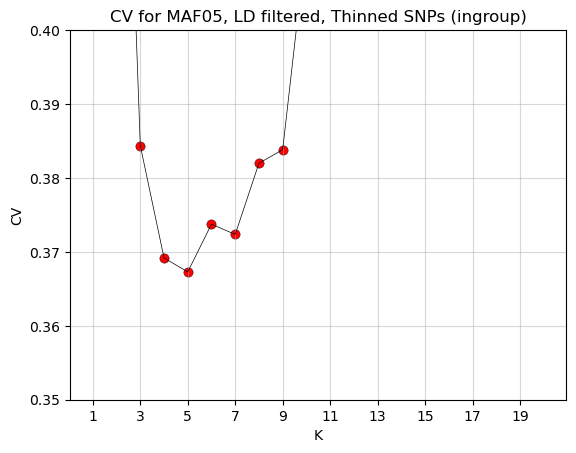

In [49]:
# #plot the cv_table
plt.plot(cv_df["k"], cv_df["cv"], color="black", linewidth=0.5)
plt.scatter(cv_df["k"], cv_df["cv"], 
            marker="o", 
            color="red", 
            edgecolor="black", 
            linewidths=0.3, 
            s=45)
plt.ylim([0.35, 0.4])
plt.xticks(list(range(1,20, 2)))
plt.grid(alpha=0.5)
plt.title("CV for MAF05, LD filtered, Thinned SNPs (ingroup)")
plt.ylabel("CV")
plt.xlabel("K")
plt.savefig("cv.svg")
plt.savefig("cv.png", dpi=300)

plt.show()

Based on these results K4-5 are ideal.

In [208]:
cm = 1/2.54 

#read in samples
samples=[]

with open("samples.list", 'r') as f:
    samples = f.read().splitlines()

#set range of ks to be investigated
ks=list(range(2,6))

for k in ks:
#for k in [4]:
    figure(figsize=(16*cm, 4*cm))


    adm_df=pd.read_csv("adm.{}.Q".format(k), sep=" ", header=None)
    adm_df["sample_name"]=samples

    x=list(range(0, len(adm_df)))

    info_df=pd.read_csv("../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",") 

    #merge the dataframes
    adm_df=adm_df.merge(info_df, how='left', on='sample_name')

    #get pca kmeans groups and add
    pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
    adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_label"]], how='left', on='sample_name')


    #adm_df=adm_df.sort_values(by=["presumed_species", "country"])
    adm_df=adm_df.sort_values(by=["kmeans_label", "country"])
    adm_df=adm_df.reset_index(drop=True)

    bottom=[0]*len(adm_df)
    for p_comp in range(0, k):
        plt.bar(x, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.1)
        bottom=bottom+adm_df[p_comp]

    #get xticks and labels
    xticks=[]
    xlabels=[]
    for kmeans_label in ["sb", "sh_nw", "sh_se"]:
        sp_idxs=adm_df.index[adm_df['kmeans_label']==kmeans_label].tolist()
        #xticks.append(sp_idxs[0])
        xticks.append(sp_idxs[-1]+.5)
        xlabel_pos=statistics.mean(sp_idxs)
        xlabels.append(kmeans_label)
    
    #plt.xlabel(adm_df["sample_name"])
    plt.ylabel("Ancestry (k={})".format(k), fontsize=10)
    
    #plt.xlabel("Samples", labelpad=20)
    plt.tight_layout()
    plt.xlim(0,len(adm_df))
    plt.ylim(0,1)
    plt.xticks(xticks)
    plt.yticks(fontsize=8)
    plt.tick_params(labelbottom=False, length=7) 
    
    plt.savefig("k{}.svg".format(k))
    plt.savefig("k{}.png".format(k))

    #display
    plt.close()
    


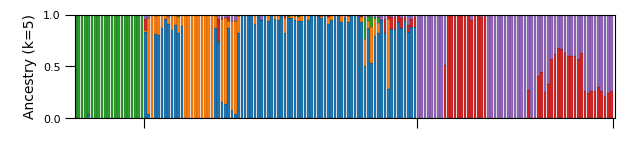

In [209]:
Image(filename=f"k5.png")


In [6]:
#read in samples
samples=[]
with open("samples.list", 'r') as f:
    samples = f.read().splitlines()

    
k=2
adm_df=pd.read_csv("adm.{}.Q".format(k), sep=" ", header=None)
adm_df["sample_name"]=samples

x=list(range(0, len(adm_df)))

info_df=pd.read_csv("../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",") 

#merge the dataframes
adm_df=adm_df.merge(info_df, how='left', on='sample_name')

#get pca kmeans groups and add
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_group"]], how='left', on='sample_name')


#adm_df=adm_df.sort_values(by=["presumed_species", "country"])
adm_df=adm_df.sort_values(by=["kmeans_group", "country"])
adm_df=adm_df.reset_index(drop=True)
adm_df

,0,1,sample_name,admera_id,barcode_label_ID,library_id,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group
0,0.994966,0.005034,sh_cameroon_SRR13579883,na,na,na,SRR13579883,s_bovis,cameroon,na,na,bovis,Rey_2019,genome,NaN,NaN,0
1,0.944116,0.055884,sbo_cdivoire_raviart_108,19047FL-14-03-09,MCFEDA1E10294,na,SRR11907393,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
2,0.939073,0.060927,sbo_cdivoire_raviart_109,19047FL-14-03-10,MCFEDA1E10295,na,SRR11907392,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
3,0.928931,0.071069,sha_cdivoire_kongobo_115,19047FL-14-03-16,MCFEDA1E10303,na,SRR11907385,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.763982,-5.476109,0
4,0.959559,0.040441,ssp_cdivoire_allokokro_102,19047FL-14-03-03,MCF28EEAF0339,na,SRR11907400,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.751133,-5.091036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.000010,0.999990,Sb_NG_be_1.5,19047FL-14-05-30,na,Sb.Be.1.5,SRR11861465,s_bovis,nigeria,na,cow,bovis,nigeria,genome,6.351932,5.643593,2
158,0.000010,0.999990,Sb_NG_en_1.1,19047FL-14-05-36,na,Sb.En.1.1,SRR11861498,s_bovis,nigeria,na,cow,bovis,nigeria,genome,6.434949,7.484255,2
159,0.000010,0.999990,bovis_senegal_SRR13579876,na,na,na,SRR13579876,s_bovis,senegal,na,na,bovis,Rey_2019,genome,NaN,NaN,2
160,0.000010,0.999990,bovis_tanzania_ERR103048,na,na,na,ERR103048,s_bovis,tanzania,na,na,bovis,na,genome,NaN,NaN,2


In [13]:
adm_df.rename(columns={"0": "k2_sh", "1": "k2_sb"}, inplace=True)

In [15]:
adm_df.to_csv("k2_adm_df.csv", sep=",", index=False)

In [16]:
adm_df=pd.read_csv("k2_adm_df.csv", sep=",")

In [17]:
adm_df

,k2_sh,k2_sb,sample_name,admera_id,barcode_label_ID,library_id,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group
0,0.994966,0.005034,sh_cameroon_SRR13579883,na,na,na,SRR13579883,s_bovis,cameroon,na,na,bovis,Rey_2019,genome,NaN,NaN,0
1,0.944116,0.055884,sbo_cdivoire_raviart_108,19047FL-14-03-09,MCFEDA1E10294,na,SRR11907393,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
2,0.939073,0.060927,sbo_cdivoire_raviart_109,19047FL-14-03-10,MCFEDA1E10295,na,SRR11907392,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
3,0.928931,0.071069,sha_cdivoire_kongobo_115,19047FL-14-03-16,MCFEDA1E10303,na,SRR11907385,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.763982,-5.476109,0
4,0.959559,0.040441,ssp_cdivoire_allokokro_102,19047FL-14-03-03,MCF28EEAF0339,na,SRR11907400,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.751133,-5.091036,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,0.000010,0.999990,Sb_NG_be_1.5,19047FL-14-05-30,na,Sb.Be.1.5,SRR11861465,s_bovis,nigeria,na,cow,bovis,nigeria,genome,6.351932,5.643593,2
158,0.000010,0.999990,Sb_NG_en_1.1,19047FL-14-05-36,na,Sb.En.1.1,SRR11861498,s_bovis,nigeria,na,cow,bovis,nigeria,genome,6.434949,7.484255,2
159,0.000010,0.999990,bovis_senegal_SRR13579876,na,na,na,SRR13579876,s_bovis,senegal,na,na,bovis,Rey_2019,genome,NaN,NaN,2
160,0.000010,0.999990,bovis_tanzania_ERR103048,na,na,na,ERR103048,s_bovis,tanzania,na,na,bovis,na,genome,NaN,NaN,2


In [19]:
adm_df.loc[adm_df["kmeans_group"] == 0].sort_values(by=["k2_sh"])

,k2_sh,k2_sb,sample_name,admera_id,barcode_label_ID,library_id,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group
66,0.737546,0.262454,Sh_NG_eb_6_2,19047FL-03-01-37,na,Sh_NG_od_3_2,SRR10012859,s_haematobium,nigeria,ebonyi,human,haematobium,nigeria,genome,6.328611,8.082222,0
68,0.844348,0.155652,Sh_NG_ed_3_2,19047FL-03-01-47,na,Sh_NG_kn_6_1,SRR10012869,s_haematobium,nigeria,edo,human,haematobium,nigeria,genome,NaN,NaN,0
70,0.890301,0.109699,Sh_NG_kw_1_10,19047FL-03-03-31,na,Sh_NG_kn_10_2,SRR10012765,s_haematobium,nigeria,kwara,human,haematobium,nigeria,genome,8.892222,5.451389,0
67,0.897316,0.102684,Sh_NG_ed_1_3,19047FL-03-01-40,na,Sh_NG_od_4_3,SRR10012863,s_haematobium,nigeria,edo,human,haematobium,nigeria,genome,NaN,NaN,0
20,0.903527,0.096473,ssp_cdivoire_raviart_99,19047FL-14-02-39,MCF2772E60119,na,SRR11907403,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.981818,0.018182,sha_sudan_schooli_129,19047FL-14-03-26,MCFF9A0BB0157,na,SRR11907528,s_sp,sudan,na,snail,unk,scan_africa,genome,14.384994,33.445852,0
77,0.984399,0.015601,sha_sudan_canal4_132,19047FL-14-03-28,MCFF9A0BB0158,na,SRR11907526,s_sp,sudan,na,snail,unk,scan_africa,genome,14.362360,33.487493,0
24,0.985559,0.014441,sh_guineabissau_SRR13579870,na,na,na,SRR13579870,s_haematobium,guineabissau,na,na,haematobium,Rey_2019,genome,NaN,NaN,0
72,0.988930,0.011070,sh_nigeria_SRR13579869,na,na,na,SRR13579869,s_haematobium,nigeria,na,na,haematobium,Rey_2019,genome,NaN,NaN,0


In [61]:
high_sb_samples=np.array(adm_df[adm_df["k2_sb"]>=0.99999]["sample_name"])
low_sb_samples =np.array(adm_df[adm_df["k2_sh"]>=0.99999]["sample_name"])

np.random.shuffle(high_sb_samples)
np.random.shuffle(low_sb_samples)

sb_ref_samples = high_sb_samples[0:int(len(high_sb_samples)*0.66)]
sh_ref_samples = low_sb_samples[0:int(len(low_sb_samples)*0.66)]

#save the lists of reference samples
np.savetxt("sh_ref.list", sh_ref_samples, delimiter=',', fmt="%s")
np.savetxt("sb_ref.list", sb_ref_samples, delimiter=',', fmt="%s")

sh_ref_samples

array(['sha_zambia_lishiko_66', 'sha_kenya_unk_49',
       'sha_madag_belesalampy_84', 'sha_madag_belesalampy_76',
       'sha_madag_belesalampy_78', 'sh_zanzibar_SRR13579868',
       'sha_unguja_kinyasini_26', 'sha_angola_cota_59',
       'sha_angola_icau_64', 'sh_tzpem_SRR8284797', 'sha_angola_icau_60',
       'sha_swaz_mkhuzweni_177', 'sha_swaz_mkhuzweni_182',
       'sha_pemba_uwandani_7', 'sha_pemba_uwandani_11',
       'sha_swaz_mkhuzweni_178', 'sha_unguja_kinyasini_27',
       'sha_madag_belesalampy_82', 'sh_tzpem_SRR8284794',
       'sha_pemba_uwandani_10', 'sha_unguja_kinyasini_30',
       'sha_angola_icau_63', 'sha_swaz_unk_186', 'sha_swaz_mkhuzweni_179',
       'sha_madag_belesalampy_87', 'sha_swaz_qomintaba_185',
       'sha_unguja_kinyasini_23', 'sha_unguja_kinyasini_28',
       'sha_madag_belesalampy_77', 'sha_swaz_njojane_190',
       'sh_tzpem_SRR8284796', 'sha_swaz_njojane_188',
       'sha_madag_belesalampy_74', 'sha_pemba_uwandani_2',
       'sha_pemba_uwandani_15', 

In [144]:
sb_ref_samples

array(['bovis_tanzania_ERR103048', 'Sb_NG_be_1.3', 'Sb_NG_au_2.6',
       'bovis_ethiopia_SRR13579874', 'sbo_cdivoire_noumousso_117',
       'ssp_cdivoire_noumousso_88', 'sbo_cdivoire_noumousso_107',
       'ssp_cdivoire_foro_101', 'Sb_NG_au_2.13', 'Sb_NG_au_1.2',
       'ssp_cdivoire_foro_103', 'sbo_cdivoire_foro_116', 'Sb_NG_be_1.5'],
      dtype=object)

In [27]:
adm_df=pd.read_csv("k2_adm_df.csv", sep=",")
adm_df.loc[adm_df["kmeans_group"] == 0, "k2_sb"].median()

0.042141

In [25]:
adm_df.loc[adm_df["kmeans_group"] == 0, "k2_sb"].min()

0.005034

In [26]:
adm_df.loc[adm_df["kmeans_group"] == 0, "k2_sb"].max()

0.262454

# Is nigeria different?

In [9]:
adm_df=pd.read_csv("k2_adm_df.csv", sep=",")
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
adm_df=adm_df.merge(pca_df[["sample_name", "kmeans_label"]], how='left', on='sample_name')
tmp_df = adm_df.loc[adm_df["kmeans_label"] == "sh_nw"].reset_index(drop=True)
tmp_df

,k2_sh,k2_sb,sample_name,admera_id,barcode_label_ID,library_id,sra_accession,presumed_species,country,locale,host,phenotype,project,data_type,lat,lon,kmeans_group,kmeans_label
0,0.994966,0.005034,sh_cameroon_SRR13579883,na,na,na,SRR13579883,s_bovis,cameroon,na,na,bovis,Rey_2019,genome,NaN,NaN,0,sh_nw
1,0.944116,0.055884,sbo_cdivoire_raviart_108,19047FL-14-03-09,MCFEDA1E10294,na,SRR11907393,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,sh_nw
2,0.939073,0.060927,sbo_cdivoire_raviart_109,19047FL-14-03-10,MCFEDA1E10295,na,SRR11907392,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.400372,-4.896099,0,sh_nw
3,0.928931,0.071069,sha_cdivoire_kongobo_115,19047FL-14-03-16,MCFEDA1E10303,na,SRR11907385,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.763982,-5.476109,0,sh_nw
4,0.959559,0.040441,ssp_cdivoire_allokokro_102,19047FL-14-03-03,MCF28EEAF0339,na,SRR11907400,s_sp,cote_d_ivoire,na,snail,unk,scan_africa,genome,7.751133,-5.091036,0,sh_nw
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,0.984399,0.015601,sha_sudan_canal4_132,19047FL-14-03-28,MCFF9A0BB0158,na,SRR11907526,s_sp,sudan,na,snail,unk,scan_africa,genome,14.362360,33.487493,0,sh_nw
78,0.971606,0.028394,sha_sudan_schoole_120,19047FL-14-03-19,MCFF9A0BB0155,na,SRR11907382,s_sp,sudan,na,snail,unk,scan_africa,genome,14.386818,33.509815,0,sh_nw
79,0.977703,0.022297,sha_sudan_schoolh_123,19047FL-14-03-21,MCFF9A0BB0155,na,SRR11907380,s_sp,sudan,na,snail,unk,scan_africa,genome,14.373361,33.479290,0,sh_nw
80,0.981818,0.018182,sha_sudan_schooli_129,19047FL-14-03-26,MCFF9A0BB0157,na,SRR11907528,s_sp,sudan,na,snail,unk,scan_africa,genome,14.384994,33.445852,0,sh_nw


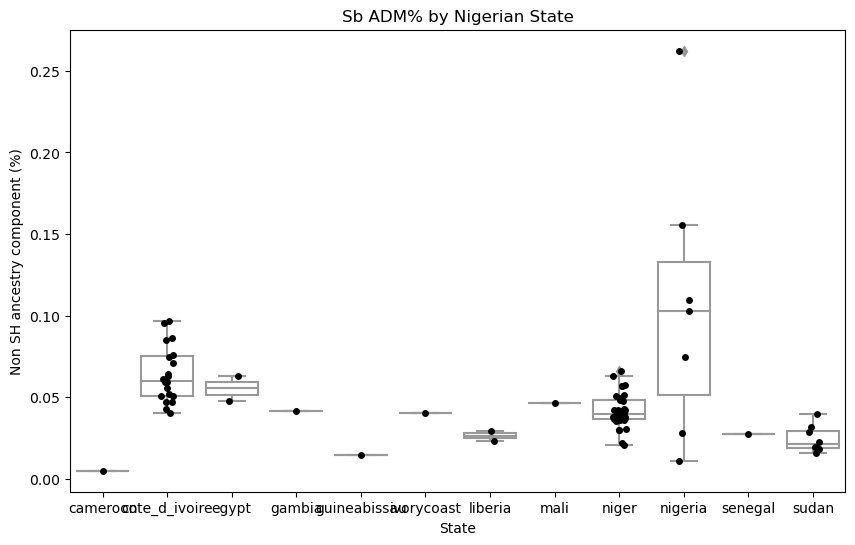

In [10]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x='country', y='k2_sb', data=tmp_df, whis=1.5, color="white")
sns.stripplot(x='country', y='k2_sb', data=tmp_df, color='black', jitter=True)
plt.title('Sb ADM% by Nigerian State')
plt.suptitle('')  # Suppress the automatic title to avoid double titles
plt.xlabel('State')
plt.ylabel('Non SH ancestry component (%)')

plt.savefig("sb_boxplot_by_state.png", dpi=600, format="png", facecolor="white")
plt.savefig("sb_sh_boxplot_by_state.svg", format="svg")

plt.show()

In [15]:
nigeria = list(tmp_df.loc[tmp_df["country"] == "nigeria", "k2_sb"])
non_nigeria_nw = list(tmp_df.loc[tmp_df["country"] != "nigeria", "k2_sb"])

In [17]:
import scikit_posthocs as sp
import scipy.stats as stats

stat, p_value = stats.kruskal(nigeria, non_nigeria_nw)

print(f"Kruskal-Wallis H test statistic: {stat}")
print(f"P-value: {p_value}")

# If the Kruskal-Wallis test is significant, perform pairwise Dunn's test
if p_value < 0.05:
    # Perform pairwise Dunn's test with Bonferroni correction
    dunn_result = sp.posthoc_dunn([nigeria, non_nigeria_nw], p_adjust='bonferroni')
    print("Pairwise comparisons using Dunn's test with Bonferroni correction:")
    print(dunn_result)
else:
    print("The differences between the groups are not statistically significant, so pairwise tests are not necessary.")

Kruskal-Wallis H test statistic: 3.8670567986230537
P-value: 0.04924280280332312
Pairwise comparisons using Dunn's test with Bonferroni correction:
          1         2
1  1.000000  0.049243
2  0.049243  1.000000


In [18]:
!pwd

/master/nplatt/sch_hae_scan/results/admixture


## Supervised (2 pops, bovis vs haem)

In [210]:
Path("{}/admixture_supervised".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/admixture_supervised".format(results_dir))

In [63]:
adm_df=pd.read_csv("../admixture/k2_adm_df.csv", sep=",")

In [64]:
samples=[]

sh_ref_samples = np.loadtxt("../admixture/sh_ref.list", dtype=str)
sb_ref_samples = np.loadtxt("../admixture/sb_ref.list", dtype=str)

with open("../admixture/samples.list", 'r') as f:
    samples = f.read().splitlines()

with open("adm.pop", 'w') as f:
    for sample in samples:
        if sample in sb_ref_samples:
            pop_label="bovis"
        elif sample in sh_ref_samples:
            pop_label="haem"
        else:
            pop_label="-"
        f.write("{}\n".format(pop_label))

In [65]:
sh_ref_samples = set(np.loadtxt("../admixture/sh_ref.list", dtype=str))
sb_ref_samples = set(np.loadtxt("../admixture//sb_ref.list", dtype=str))

with open("../admixture/samples.list") as f, open("adm.pop", "w") as out_file:
    for sample in map(str.strip, f):
        pop_label = "bovis" if sample in sb_ref_samples else "haem" if sample in sh_ref_samples else "-"
        out_file.write(f"{pop_label}\n")

In [66]:
%%bash 
#create link to ped file
ln -s ../admixture/adm.ped

#run supervised admixture
conda run -n popstructure --cwd .  \
    admixture \
        -j48 \
        --cv=1000 \
        --supervised \
        adm.ped \
        2

****                   ADMIXTURE Version 1.3.0                  ****
****                    Copyright 2008-2015                     ****
****           David Alexander, Suyash Shringarpure,            ****
****                John  Novembre, Ken Lange                   ****
****                                                            ****
****                 Please cite our paper!                     ****
****   Information at www.genetics.ucla.edu/software/admixture  ****

Parallel execution requested.  Will use 48 threads.
Cross-validation will be performed.  Folds=1000.
Random seed: 43
Point estimation method: Block relaxation algorithm
Convergence acceleration algorithm: QuasiNewton, 3 secant conditions
Point estimation will terminate when objective function delta < 0.0001
Estimation of standard errors disabled; will compute point estimates only.
Supervised analysis mode.  Examining .pop file...
Size of G: 162x26418
Performing five EM steps to prime main algorithm
1 (EM) 	Elap

In [211]:
cm = 1/2.54 

# read in samples from file
with open("../admixture/samples.list") as f:
    samples = [line.strip() for line in f]

# set up plot
fig, ax = plt.subplots(figsize=(16*cm, 4*cm))
k = 2

# load admixture data for k clusters
adm_df = pd.read_csv(f"adm.{k}.Q", sep=" ", header=None)
adm_df["sample_name"] = samples

# load metadata for each sample
info_df = pd.read_csv("../../data/seq_and_sample_docs/all_sh_sb_sample_data.csv", sep=",")

# merge the admixture data with metadata based on sample names
adm_df = pd.merge(adm_df, info_df, on="sample_name")

# load PCA data and add the k-means clustering labels
pca_df = pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
adm_df = pd.merge(adm_df, pca_df[["sample_name", "kmeans_label"]], on="sample_name")

# sort the samples by k-means label and country
adm_df.sort_values(["kmeans_label", "country"], inplace=True)
adm_df.reset_index(drop=True, inplace=True)

#get xticks and labels
xticks=[]
xlabels=[]
for kmeans_label in ["sb", "sh_nw", "sh_se"]:
    sp_idxs=adm_df.index[adm_df['kmeans_label']==kmeans_label].tolist()
    #xticks.append(sp_idxs[0])
    xticks.append(sp_idxs[-1]+.5)
    xlabel_pos=statistics.mean(sp_idxs)
    xlabels.append(kmeans_label)
        
# plot stacked bar chart for each principal component
bottom = 0
for p_comp in range(k):
    ax.bar(adm_df.index, adm_df[p_comp], bottom=bottom, edgecolor="black", linewidth=0.1)
    bottom += adm_df[p_comp]

# set plot labels and limits
ax.set_ylabel(f"Ancestry (Sup)", fontsize=10)
#ax.set_xlabel("Samples")
ax.set_xlim(0, len(adm_df))
ax.set_ylim(0, 1)
ax.set_xticks(xticks)
plt.yticks(fontsize=8)
ax.tick_params(axis="x", labelbottom=False, length=7)

# save and show plot
fig.tight_layout()
fig.savefig(f"k{k}_supervised.svg")
fig.savefig(f"k{k}_supervised.png")
plt.close()


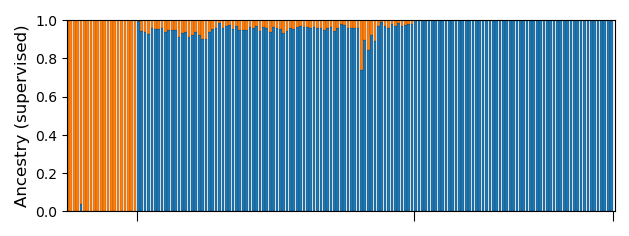

In [207]:
Image(filename=f"k2_supervised.png")

# Fst

In [7]:
Path("{}/fst".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/fst".format(results_dir))

In [8]:
pca_df=pd.read_csv(f"{results_dir}/pca/pca_df.csv", sep=",")

In [6]:
filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/autosomes_unrelated.vcf')

In [7]:
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])
snv_ids=filtered_callset['variants/ID']

In [8]:
#get kmeans_pop_idxs

#now get an index for each sample/population
samples = list(filtered_callset["samples"])

#initiate list that will store the vcf idx for each sample in relation to the pca k group
kmeans_pop_idxs = {}

for pop in pca_df["kmeans_label"].unique():
    k_samples = list(pca_df.loc[pca_df["kmeans_label"] == pop, "sample_name"])
    kmeans_pop_idxs[pop] = [samples.index(k_sample) for k_sample in k_samples if k_sample in samples]

kmeans_pop_idxs["sh"] = kmeans_pop_idxs["sh_nw"] + kmeans_pop_idxs["sh_se"]

## Fst between species and populations of interest

In [10]:
#this is for mappable snvs
fst_window_size = 10_000

# Create a dictionary to store the population combinations
pop_combos = { "sh_sb":     ["sh",    "sb"],
               "sh_nw_se":  ["sh_nw", "sh_se"],
               "sh_nw_sb":  ["sh_nw", "sb"],
               "sh_se_sb":  ["sh_se", "sb"],
               "sh_sg":     ["sh",    "s_guineensis"],
               "sh_si":     ["sh",    "s_intercalatum"],
               "sh_smar":   ["sh",    "s_margrebowiei"],
               "sh_smat":   ["sh",    "s_matthei"]
             }

# Use a list comprehension to calculate fsts and ses
fsts, ses = zip(*[allel.average_weir_cockerham_fst(gt, [kmeans_pop_idxs[pop_1], kmeans_pop_idxs[pop_2]], fst_window_size)[:2]
                  for pop_1, pop_2 in pop_combos.values()])

# Use zip() to create pop_1s and pop_2s
pop_1s, pop_2s = zip(*pop_combos.values())

# Create the fst_df DataFrame
fst_df = pd.DataFrame({ "fst": fsts,
                        "se": ses,
                        "pop_1": pop_1s,
                        "pop_2": pop_2s,
                        "window_size": fst_window_size
                       })

#save and display df
fst_df.to_csv("fsts.csv")
fst_df

,fst,se,pop_1,pop_2,window_size
0,0.756309,0.003266,sh,sb,10000
1,0.181113,0.004789,sh_nw,sh_se,10000
2,0.704016,0.003384,sh_nw,sb,10000
3,0.780253,0.002190,sh_se,sb,10000
4,0.817517,0.003499,sh,s_guineensis,10000
5,0.848336,0.003054,sh,s_intercalatum,10000
6,0.876969,0.002563,sh,s_margrebowiei,10000
7,0.850079,0.003220,sh,s_matthei,10000


## Fst across the genome

In [9]:
filtered_callset=allel.read_vcf(f'{results_dir}/post_phase_filtering/chrs_unrelated.vcf')

In [10]:
gt=allel.GenotypeArray(filtered_callset['calldata/GT'])
snv_ids=filtered_callset['variants/ID']

In [11]:
#get kmeans_pop_idxs

#now get an index for each sample/population
samples = list(filtered_callset["samples"])

#initiate list that will store the vcf idx for each sample in relation to the pca k group
kmeans_pop_idxs = {}

for pop in pca_df["kmeans_label"].unique():
    k_samples = list(pca_df.loc[pca_df["kmeans_label"] == pop, "sample_name"])
    kmeans_pop_idxs[pop] = [samples.index(k_sample) for k_sample in k_samples if k_sample in samples]

kmeans_pop_idxs["sh"] = kmeans_pop_idxs["sh_nw"] + kmeans_pop_idxs["sh_se"]

In [12]:
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [43]:
fst_dfs={}

window_size=10_000

for pop1, pop2 in [("sh_nw", "sh_se"),
                   ("sh_nw", "sb"), 
                   ("sh_se", "sb"), 
                   ("sh", "sb")]:
    
    comp = f"{pop1}_v_{pop2}"
    
    chrs=[]
    fsts=[]
    windows=[]
    counts=[]

    tmp_df = pd.DataFrame()

    for chrom in uniq_chroms:
        mask = (chroms == chrom)

        chrom_gt  = gt[mask]
        chrom_pos = poss[mask]

        chr_fsts, chr_windows, chr_counts = allel.windowed_weir_cockerham_fst(chrom_pos, chrom_gt, [kmeans_pop_idxs[pop1], kmeans_pop_idxs[pop2]], size=window_size, start=1)

        chrs.extend([chrom] * len(chr_fsts))
        fsts.extend(chr_fsts)
        windows.extend(chr_windows)
        counts.extend(chr_counts)

    tmp_df["chr"] = chrs
    tmp_df["start"]=[window[0] for window in windows]
    tmp_df["stop"]=[window[1] for window in windows]
    tmp_df["counts"]=counts
    tmp_df["fst"] = fsts

    tmp_df.to_csv(f"{comp}_genome_wide_fst.csv", header=True, sep=",", index=False)
    
    fst_dfs[comp]=tmp_df

/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:409: RuntimeWarning: invalid value encountered in scalar divide
  return np.nansum(wa) / (np.nansum(wa) + np.nansum(wb) + np.nansum(wc))


In [44]:
#combine data into a single fst_df
fst_df = fst_dfs['sh_nw_v_sh_se']
fst_df["nw_sb"]=fst_dfs['sh_nw_v_sb']['fst']
fst_df["se_sb"]=fst_dfs['sh_se_v_sb']['fst']
fst_df["sh_sb"]=fst_dfs['sh_v_sb']['fst']
fst_df.rename({"fst": "nw_se"}, axis=1, inplace=True)
fst_df.to_csv(f"genome_wide_fsts.csv", header=True, sep=",", index=False)
fst_df

,chr,start,stop,counts,nw_se,nw_sb,se_sb,sh_sb
0,NC_067195.1,1,10000,0,NaN,NaN,NaN,NaN
1,NC_067195.1,10001,20000,145,0.108801,0.401244,0.456864,0.404991
2,NC_067195.1,20001,30000,77,0.077458,0.073799,0.296456,0.123940
3,NC_067195.1,30001,40000,172,0.044535,0.441660,0.446748,0.470867
4,NC_067195.1,40001,50000,10,0.015244,0.115416,0.240411,0.191498
...,...,...,...,...,...,...,...,...
39203,NC_067202.1,19430001,19440000,524,0.031291,0.428523,0.425393,0.427166
39204,NC_067202.1,19440001,19450000,118,0.035224,0.297370,0.282695,0.294040
39205,NC_067202.1,19450001,19460000,615,0.028665,0.313599,0.356453,0.326786
39206,NC_067202.1,19460001,19470000,1426,0.038723,0.328646,0.325193,0.324127


In [45]:
fst_df["chr"].value_counts()

NC_067196.1    9331
NC_067195.1    8915
NC_067198.1    4833
NC_067197.1    4737
NC_067199.1    4678
NC_067201.1    2551
NC_067200.1    2215
NC_067202.1    1948
Name: chr, dtype: int64

In [215]:
fst_df = pd.read_csv("genome_wide_fsts.csv", sep=",", header=0)
fst_df

,chr,start,stop,sh_nw_v_sh_se,sh_nw_v_sb,sh_se_v_sb,sh_v_sb,genomic_position
0,NC_067196.1,124225,200439,0.353349,0.083810,0.386162,0.101811,124225
1,NC_067196.1,200439,209975,0.361510,0.065494,0.517334,0.137269,200439
2,NC_067196.1,209975,225798,0.275900,0.063367,0.286367,0.083720,209975
3,NC_067196.1,225798,284021,0.357195,0.053273,0.374769,0.088787,225798
4,NC_067196.1,284021,298172,0.454401,0.019773,0.429143,0.080927,284021
...,...,...,...,...,...,...,...,...
57172,NC_067202.1,19457726,19462462,0.023543,0.328911,0.362141,0.340373,302852474
57173,NC_067202.1,19462462,19465964,0.038999,0.297743,0.299051,0.293121,302857210
57174,NC_067202.1,19465964,19468922,0.053445,0.330538,0.320759,0.323886,302860712
57175,NC_067202.1,19468922,19473450,0.077793,0.464485,0.383035,0.419540,302863670


In [228]:
pos_df = pd.read_csv(f"{proj_dir}/results/fig_plotting_info/plotting_info.csv", sep=",") #generated in prep_figs_info.ipynb

offsets=dict(zip(pos_df["contig"], pos_df["x_start"].astype(int)))
colors=dict(zip(pos_df["contig"], pos_df["color"].astype(str)))

x=[]
c=[]

for index, row in fst_df.iterrows():
    chrom = row["chr"]
    
    offset=offsets[chrom]
    color = colors[chrom]
    
    x.append(row["start"] + offset)
    c.append(color)
    
fst_df["genomic_position"] = x
fst_df["color"] = c

fst_df.to_csv(f"genome_wide_fsts.csv", header=True, sep=",", index=False)


In [238]:
group[comp]

52942    0.285257
52943    0.360983
52944    0.471746
52945    0.430072
52946    0.478736
           ...   
57172    0.340373
57173    0.293121
57174    0.323886
57175    0.419540
57176    0.490160
Name: sh_v_sb, Length: 4235, dtype: float64

52942    NC_067202.1
52943    NC_067202.1
52944    NC_067202.1
52945    NC_067202.1
52946    NC_067202.1
            ...     
57172    NC_067202.1
57173    NC_067202.1
57174    NC_067202.1
57175    NC_067202.1
57176    NC_067202.1
Name: chr, Length: 4235, dtype: object

In [253]:
for pop1, pop2 in [("sh_nw", "sh_se"), 
                   ("sh_nw", "sb"), 
                   ("sh_se", "sb"), 
                   ("sh", "sb")]:
    
    comp = f"{pop1}_v_{pop2}"
    
    print(comp)

sh_nw_v_sh_se
sh_nw_v_sb
sh_se_v_sb
sh_v_sb


In [259]:
fst_df[comp].median()

0.803111388677723

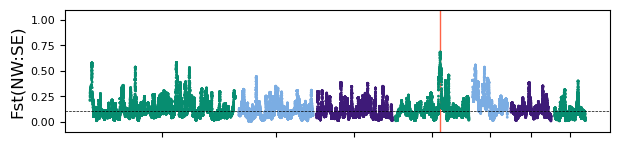

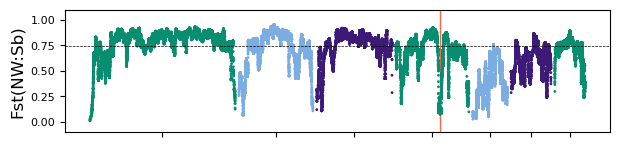

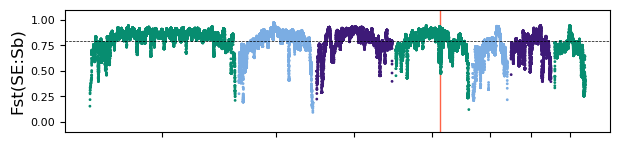

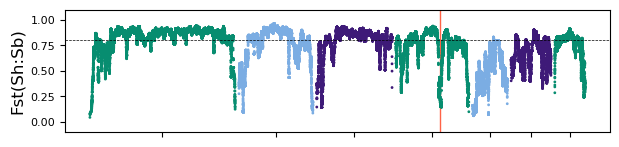

In [262]:
comp_labels = {"sh_nw_v_sh_se": "NW:SE",
               "sh_nw_v_sb":    "NW:Sb",
               "sh_se_v_sb":    "SE:Sb",
               "sh_v_sb":       "Sh:Sb"}


for pop1, pop2 in [("sh_nw", "sh_se"), 
                   ("sh_nw", "sb"), 
                   ("sh_se", "sb"), 
                   ("sh", "sb")]:
    
    comp = f"{pop1}_v_{pop2}"

    
    # Create the Manhattan plot figure and axis
    #fig, ax = plt.subplots(figsize=(15, 5))
    cm = 1/2.54
    fig, ax = plt.subplots(figsize=(16*cm, 4*cm))

    # Define three shades of grey
    shades_of_grey = ['#808080', '#A0A0A0', '#C0C0C0']

    # Create the colormap
    custom_cmap = ListedColormap(shades_of_grey)

    #plot position of the invadolysin locus
    #plt.axvline(x=invad_loc, ymin=-3, ymax=3)

    # Iterate through the groups of chromosomes and plot each group with a different color

    for i, (chrom, group) in enumerate(fst_df.groupby("chr")):
        color = custom_cmap(i % custom_cmap.N)  # Get a color from the colormap
        ax.scatter(group["genomic_position"], medfilt(group[comp], kernel_size=51), s=1, alpha=1, color=group["color"], label=f'{chrom}', zorder=2)

    # # Plot the significant data points (Bonferroni corrected) in red
    # ax.scatter(sig_bonf["genomic_position"], sig_bonf["xpehh"], s=10, alpha=1, color='red', label='Sig.')

    # Set the x-axis and y-axis labels
    ax.set_ylabel(f"Fst({comp_labels[comp]})", fontsize=12)
    ax.tick_params(axis='y', labelsize=8)


    x_ticks  = list(pos_df["mid_tick"].astype(int)[0:7])
    x_labels = list(pos_df["contig"].astype(str)[0:7])
    ax.set_xticks(x_ticks)
    ax.set_xticklabels([])
    ax.set_ylim(-0.1, 1.1)
    
    #plot invadolysin line
    invad_loc_x = offsets["NC_067199.1"] + (28_467_137+28_495_140)/2
    invad_loc_x
    ax.axvline(x=invad_loc_x, color='tomato', linestyle="solid", linewidth=1, zorder=1)
    
    fst_med = fst_df[comp].median()
    ax.axhline(y=fst_med, color='black', linestyle="dashed", linewidth=0.5)

    #ax.set_title(comp, fontsize=12)



    # Add the legend outside the plot in the upper right corner
    #ax.legend(markerscale=3, fontsize=14, loc='upper left', bbox_to_anchor=(1, 1))

    # Adjust the layout to fit the plot in the figure
    plt.tight_layout()

    # Show the plot
    plt.show()

    # Save the plot as an SVG file
    fig.savefig(f'fst_genome_wide_{comp}.svg', format='svg')

    # Save the plot as a 300 dpi PNG file
    fig.savefig(f'fst_genome_wide_{comp}.png', dpi=300, format='png')


## Get FST between reference populations as designated in the admixture analyses

In [85]:
#get fst between "ref" samples

#read ref samples to an array (from ADM analyses above)
sh_ref_samples = np.genfromtxt(f"{results_dir}/admixture/sh_ref.list", delimiter=',', dtype=str)
sb_ref_samples = np.genfromtxt(f"{results_dir}/admixture/sb_ref.list", delimiter=',', dtype=str)

#get ac counts from each ref pop
sh_ref_sample_idxs = [samples.index(ref_sample) for ref_sample in sh_ref_samples]
sb_ref_sample_idxs = [samples.index(ref_sample) for ref_sample in sb_ref_samples]

In [86]:
fst, se, vb, vj = allel.average_weir_cockerham_fst(gt, 
                                                   [sb_ref_sample_idxs, sh_ref_sample_idxs], 
                                                   fst_window_size)
print("Fst between reference samples Sh vs. Sb = {} (SE {})".format(fst, se))

Fst between reference samples Sh vs. Sb = 0.8564927345758375 (SE 0.002830974062347981)


In [87]:
#run fst at each site
a, b, c = allel.weir_cockerham_fst(gt, [sb_ref_sample_idxs, sh_ref_sample_idxs])

fsts = (np.sum(a, axis=1) / (np.sum(a, axis=1) + np.sum(b, axis=1) + np.sum(c, axis=1)))

/tmp/ipykernel_201493/831756883.py:4: RuntimeWarning: invalid value encountered in divide
  fsts = (np.sum(a, axis=1) / (np.sum(a, axis=1) + np.sum(b, axis=1) + np.sum(c, axis=1)))


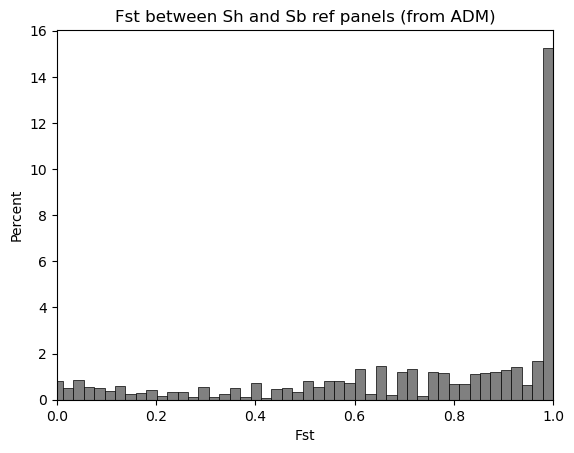

In [91]:
n_bins=50

plt.hist(fsts, n_bins, density=True, edgecolor='black', linewidth=0.5, color="grey")
plt.xlabel("Fst")
plt.ylabel("Percent")
plt.title("Fst between Sh and Sb ref panels (from ADM)")
plt.xlim(0,1)
plt.show()

## Get SNPs with high fst between ref. populations (used in hybrid index)

In [92]:
#how many snvs are fixed between the two populations
len(fsts[fsts==1])

1501758

In [93]:
len(fsts)

6151258

In [94]:
snvs_fst_eq_1=snv_ids[fsts==1]
np.savetxt("snvs_fst_eq_1.list", snvs_fst_eq_1, delimiter=',', fmt="%s")

In [96]:
%%bash

#extract these variants with vcftools
conda run -n popstructure --cwd . --live-stream \
    vcftools \
        --vcf ../post_phase_filtering/autosomes_unrelated_maf05.vcf \
        --snps snvs_fst_eq_1.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >fst_eq_1.vcf

#now ld filter
conda run -n popstructure --cwd . --live-stream \
    plink \
        --vcf fst_eq_1.vcf \
        --allow-extra-chr \
        --double-id \
        --indep-pairwise 25 5 0.20 \
        --out fst_eq_1_ld_filtered

#remove linked snps
conda run -n popstructure --cwd . --live-stream \
    vcftools \
        --vcf fst_eq_1.vcf \
        --exclude mappable_fst_eq_1_ld_filtered.prune.out \
        --recode \
        --recode-INFO-all \
        --stdout \
        >fst_eq_1_ld_filtered.vcf


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf ../post_phase_filtering/autosomes_unrelated_maf05.vcf
	--recode-INFO-all
	--recode
	--snps snvs_fst_eq_1.list
	--stdout

After filtering, kept 166 out of 166 Individuals
Outputting VCF file...
After filtering, kept 1501758 out of a possible 6151258 Sites
Run Time = 117.00 seconds


PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to fst_eq_1_ld_filtered.log.
Options in effect:
  --allow-extra-chr
  --double-id
  --indep-pairwise 25 5 0.20
  --out fst_eq_1_ld_filtered
  --vcf fst_eq_1.vcf

1031287 MB RAM detected; reserving 515643 MB for main workspace.
--vcf: fst_eq_1_ld_filtered-temporary.bed + fst_eq_1_ld_filtered-temporary.bim
+ fst_eq_1_ld_filtered-temporary.fam written.
1501758 variants loaded from .bim file.
166 people (0 males, 0 females, 166 ambiguous) loaded from .fam.
Ambiguous sex IDs written to fst_eq_1_ld_filtered.nosex .
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 166 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889


VCFtools - 0.1.16
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--vcf fst_eq_1.vcf
	--recode-INFO-all
	--recode
	--exclude mappable_fst_eq_1_ld_filtered.prune.out
	--stdout

After filtering, kept 166 out of 166 Individuals
Outputting VCF file...
After filtering, kept 441979 out of a possible 1501758 Sites
Run Time = 32.00 seconds


# Mantel test

In [163]:
Path("{}/mantel".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/mantel".format(results_dir))

In [164]:
#read in sample info
info_df=pd.read_csv("{}/data/seq_and_sample_docs/all_sh_sb_sample_data.csv".format(proj_dir), sep=",") 

#get the pca kmeans groups
pca_df=pd.read_csv("{}/results/pca/pca_df.csv".format(proj_dir), sep=",")
pca_df=pca_df[["sample_name", "kmeans_group", "kmeans_label"]]

#add to the sample info
info_df=info_df.merge(pca_df, how='right', on='sample_name')

In [165]:
#samples with no lat/lon info cause major problems will need to exclude downstream
sh_nw_samples = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["kmeans_label"] == "sh_nw", "sample_name" ].values
sh_se_samples = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["kmeans_label"] == "sh_se", "sample_name" ].values
sb_samples    = info_df.dropna(axis=0, subset=["lat", "lon"]).loc[info_df["kmeans_label"] == "sb", "sample_name" ].values

np.savetxt("sh_nw_samples.list", sh_nw_samples, delimiter=',', fmt="%s")
np.savetxt("sh_se_samples.list", sh_se_samples, delimiter=',', fmt="%s")
np.savetxt("sb_samples.list", sb_samples, delimiter=',', fmt="%s")

In [167]:
%%bash

cat sh_nw_samples.list  sh_se_samples.list sb_samples.list >ingroup_samples.list

conda run -n popstructure --cwd . --live-stream \
    vcftools \
        --vcf ../filter_genotypes/mappable_snvs.vcf \
        --maf 0.05 \
        --keep ingroup_samples.list \
        --recode \
        --recode-INFO-all \
        --stdout \
        >mantel.vcf

## Calculate genetic distances 
calculated wtih `VCF2Dis` from https://github.com/BGI-shenzhen/VCF2Dis.  Cloned into `sch_hae_scan/bin`

In [191]:
#get the genetic data
vcf_reader = vcf.Reader(open('mantel.vcf', 'r'))
#get the sample order
samples=vcf_reader.samples

In [ ]:
%%bash

~/sch_hae_scan/bin/VCF2Dis/bin/VCF2Dis -InPut smantelh.vcf -OutPut mantel_p_distance.tsv

In [209]:
#read in distance matrix
gen_df = pd.read_table("mantel_p_distance.tsv", sep="\t", header=None, index_col=0, skiprows=[0])

#VCF2Dis only keeps the first 20 chars in the sample name... so need to re-header
gen_df.index=samples
gen_df.columns=samples
gen_df.to_csv("mantel_p_distance.csv", sep=",")
gen_df

,Sb_NG_au_1.2,Sb_NG_au_2.10,Sb_NG_au_2.13,Sb_NG_au_2.5,Sb_NG_au_2.6,Sb_NG_be_1.10,Sb_NG_be_1.3,Sb_NG_be_1.5,Sb_NG_en_1.1,Sh_NG_eb_6_2,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
Sb_NG_au_1.2,0.000000,0.131414,0.130567,0.123673,0.133479,0.138487,0.138047,0.139565,0.137195,0.607656,...,0.673802,0.677792,0.687424,0.686113,0.690534,0.682677,0.686049,0.682013,0.682106,0.711361
Sb_NG_au_2.10,0.131414,0.000000,0.133060,0.125256,0.131524,0.138589,0.138525,0.139375,0.137232,0.605154,...,0.671416,0.675978,0.685582,0.685096,0.689279,0.680746,0.684091,0.680638,0.680312,0.709620
Sb_NG_au_2.13,0.130567,0.133060,0.000000,0.123730,0.131377,0.137550,0.137009,0.138607,0.136884,0.607040,...,0.673536,0.677319,0.687281,0.686922,0.690918,0.682147,0.685731,0.682445,0.681987,0.711162
Sb_NG_au_2.5,0.123673,0.125256,0.123730,0.000000,0.124462,0.129912,0.129845,0.131333,0.130144,0.604908,...,0.671399,0.675360,0.684936,0.684015,0.688549,0.680483,0.683658,0.680221,0.679980,0.710109
Sb_NG_au_2.6,0.133479,0.131524,0.131377,0.124462,0.000000,0.137950,0.139023,0.139497,0.136131,0.606011,...,0.672750,0.676290,0.686568,0.685338,0.690063,0.680987,0.684277,0.681226,0.681008,0.710233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,0.682677,0.680746,0.682147,0.680483,0.680987,0.675128,0.676105,0.675591,0.674796,0.171413,...,0.122009,0.089942,0.098590,0.084684,0.090068,0.000000,0.097598,0.089012,0.089984,0.109387
ssp_niger_libore_167,0.686049,0.684091,0.685731,0.683658,0.684277,0.678250,0.679304,0.679045,0.678591,0.181795,...,0.118892,0.104165,0.088729,0.095421,0.087935,0.097598,0.000000,0.101232,0.098020,0.097215
ssp_niger_libore_168,0.682013,0.680638,0.682445,0.680221,0.681226,0.674857,0.675725,0.676202,0.674472,0.169057,...,0.124545,0.096090,0.098624,0.087778,0.093256,0.089012,0.101232,0.000000,0.085708,0.108372
ssp_niger_libore_169,0.682106,0.680312,0.681987,0.679980,0.681008,0.674412,0.675636,0.675341,0.674373,0.170109,...,0.123967,0.094921,0.096624,0.089336,0.095068,0.089984,0.098020,0.085708,0.000000,0.104821


## Get geo distances

In [210]:
km_dists=np.array([])
for s1 in samples:
    s1_lat=info_df.loc[info_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=info_df.loc[info_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in samples:
        s2_lat=info_df.loc[info_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=info_df.loc[info_df["sample_name"] == s2]["lon"].values[0]
        
        km_dists=np.append(km_dists, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        
#reshape into a 2d matrix
km_dists.shape=(len(samples), len(samples))

#convert to a df
km_df=pd.DataFrame(data=km_dists, columns=samples, index=samples)
km_df.to_csv("mantel_geo_distance.csv", sep=",")
km_df

,Sb_NG_au_1.2,Sb_NG_au_2.10,Sb_NG_au_2.13,Sb_NG_au_2.5,Sb_NG_au_2.6,Sb_NG_be_1.10,Sb_NG_be_1.3,Sb_NG_be_1.5,Sb_NG_en_1.1,Sh_NG_eb_6_2,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
Sb_NG_au_1.2,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,1232.381385,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,3503.203945
Sb_NG_au_2.10,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,1232.381385,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,3503.203945
Sb_NG_au_2.13,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,1232.381385,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,3503.203945
Sb_NG_au_2.5,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,1232.381385,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,3503.203945
Sb_NG_au_2.6,0.000000,0.000000,0.000000,0.000000,0.000000,105.512106,105.512106,105.512106,151.296883,216.223106,...,1232.381385,832.036436,832.036436,832.036436,832.344503,832.036436,832.344503,832.344503,834.194103,3503.203945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,832.036436,832.036436,832.036436,832.036436,832.036436,868.509631,868.509631,868.509631,965.629789,1015.379965,...,1022.178587,0.000000,0.000000,0.000000,0.314163,0.000000,0.314163,0.314163,2.158047,4321.752445
ssp_niger_libore_167,832.344503,832.344503,832.344503,832.344503,832.344503,868.808416,868.808416,868.808416,965.941774,1015.693312,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
ssp_niger_libore_168,832.344503,832.344503,832.344503,832.344503,832.344503,868.808416,868.808416,868.808416,965.941774,1015.693312,...,1022.156004,0.314163,0.314163,0.314163,0.000000,0.314163,0.000000,0.000000,1.849721,4322.066439
ssp_niger_libore_169,834.194103,834.194103,834.194103,834.194103,834.194103,870.647892,870.647892,870.647892,967.783870,1017.525832,...,1022.410121,2.158047,2.158047,2.158047,1.849721,2.158047,1.849721,1.849721,0.000000,4323.887609


## Mantel Tests

In [211]:
# Need to do 4 comparisons
# Sb
# Sh
# NW
# SE

#get idecies of each sample type/species of interest

labels = []

for sample in samples:
    labels.append(pca_df.loc[pca_df["sample_name"] == sample, "kmeans_label"].values[0])
    
sb_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sb"]
nw_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_nw"]
se_idx=matching_indices = [i for i, s in enumerate(labels) if s == "sh_se"]
sh_idx=nw_idx + se_idx


In [235]:
gen_df.iloc

,Sb_NG_au_1.2,Sb_NG_au_2.10,Sb_NG_au_2.13,Sb_NG_au_2.5,Sb_NG_au_2.6,Sb_NG_be_1.10,Sb_NG_be_1.3,Sb_NG_be_1.5,Sb_NG_en_1.1,Sh_NG_eb_6_2,...,ssp_cdivoire_raviart_99,ssp_niger_libore_156,ssp_niger_libore_157,ssp_niger_libore_159,ssp_niger_libore_165,ssp_niger_libore_166,ssp_niger_libore_167,ssp_niger_libore_168,ssp_niger_libore_169,ssp_zambia_kafue_71
Sb_NG_au_1.2,0.000000,0.131414,0.130567,0.123673,0.133479,0.138487,0.138047,0.139565,0.137195,0.607656,...,0.673802,0.677792,0.687424,0.686113,0.690534,0.682677,0.686049,0.682013,0.682106,0.711361
Sb_NG_au_2.10,0.131414,0.000000,0.133060,0.125256,0.131524,0.138589,0.138525,0.139375,0.137232,0.605154,...,0.671416,0.675978,0.685582,0.685096,0.689279,0.680746,0.684091,0.680638,0.680312,0.709620
Sb_NG_au_2.13,0.130567,0.133060,0.000000,0.123730,0.131377,0.137550,0.137009,0.138607,0.136884,0.607040,...,0.673536,0.677319,0.687281,0.686922,0.690918,0.682147,0.685731,0.682445,0.681987,0.711162
Sb_NG_au_2.5,0.123673,0.125256,0.123730,0.000000,0.124462,0.129912,0.129845,0.131333,0.130144,0.604908,...,0.671399,0.675360,0.684936,0.684015,0.688549,0.680483,0.683658,0.680221,0.679980,0.710109
Sb_NG_au_2.6,0.133479,0.131524,0.131377,0.124462,0.000000,0.137950,0.139023,0.139497,0.136131,0.606011,...,0.672750,0.676290,0.686568,0.685338,0.690063,0.680987,0.684277,0.681226,0.681008,0.710233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ssp_niger_libore_166,0.682677,0.680746,0.682147,0.680483,0.680987,0.675128,0.676105,0.675591,0.674796,0.171413,...,0.122009,0.089942,0.098590,0.084684,0.090068,0.000000,0.097598,0.089012,0.089984,0.109387
ssp_niger_libore_167,0.686049,0.684091,0.685731,0.683658,0.684277,0.678250,0.679304,0.679045,0.678591,0.181795,...,0.118892,0.104165,0.088729,0.095421,0.087935,0.097598,0.000000,0.101232,0.098020,0.097215
ssp_niger_libore_168,0.682013,0.680638,0.682445,0.680221,0.681226,0.674857,0.675725,0.676202,0.674472,0.169057,...,0.124545,0.096090,0.098624,0.087778,0.093256,0.089012,0.101232,0.000000,0.085708,0.108372
ssp_niger_libore_169,0.682106,0.680312,0.681987,0.679980,0.681008,0.674412,0.675636,0.675341,0.674373,0.170109,...,0.123967,0.094921,0.096624,0.089336,0.095068,0.089984,0.098020,0.085708,0.000000,0.104821


In [247]:
samples_with_geo_data.shape

(135,)

Mantel test - sb: r2=0.63, p=0.001, n=16
Mantel test - sh_nw: r2=0.01, p=0.912, n=69
Mantel test - sh_se: r2=0.49, p=0.001, n=50


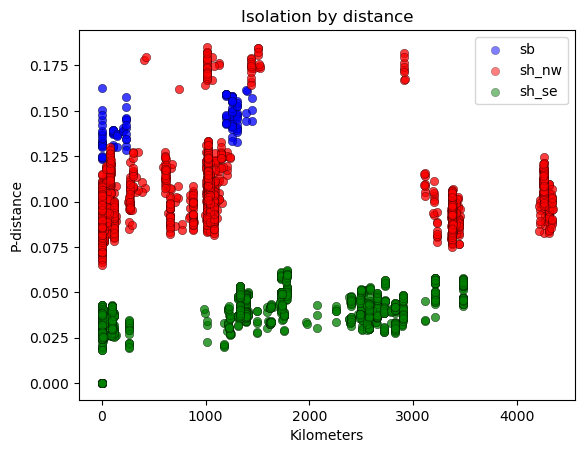

In [248]:
samples_with_geo_data = info_df.iloc[info_df['lat'].notnull().values]["sample_name"].values

for idx, color, label in [(sb_idx, "blue", "sb"),
                          (nw_idx, "red", "sh_nw"),
                          (se_idx, "green", "sh_se") ]:
    
    #subsample genetic and physical distance matricies
    g=gen_df.iloc[idx, idx]
    k=km_df.iloc[idx, idx]

    # #get rid of anything that didn't have lat lon
    # mask=k.index.isin(samples_with_geo_data)
    # g=g.loc[mask, mask]
    # k=k.loc[mask, mask]

    #conduct the mantel test
    r2, p, n = mantel(g, k, permutations=1000)
    print("Mantel test - {}: r2={:.2f}, p={:.3f}, n={}".format(label, r2, p, n))
    #add points to scatter plot
    gs=g.values.flatten()
    ks=k.values.flatten()
    plt.scatter(ks, gs, alpha=0.5, color=color, edgecolors="black", linewidth=0.3, label=label)

    
plt.legend()
plt.title("Isolation by distance")
plt.xlabel("Kilometers")
plt.ylabel("P-distance")
plt.show()

# Clines


In [314]:
Path("{}/clines".format(results_dir)).mkdir(parents=True, exist_ok=True)
os.chdir("{}/clines".format(results_dir))

In [320]:
pca_df=pd.read_csv("{}/pca/pca_df.csv".format(results_dir), sep=",")
cline_df = pca_df[["sample_name", "country", "locale", "host", "lat", "lon", "kmeans_label", "pca_species"]]
cline_df

,sample_name,country,locale,host,lat,lon,kmeans_label,pca_species
0,Sb_NG_au_1.2,nigeria,na,cow,7.067448,6.271139,sb,s_bovis
1,Sb_NG_au_2.10,nigeria,na,cow,7.067448,6.271139,sb,s_bovis
2,Sb_NG_au_2.13,nigeria,na,cow,7.067448,6.271139,sb,s_bovis
3,Sb_NG_au_2.5,nigeria,na,cow,7.067448,6.271139,sb,s_bovis
4,Sb_NG_au_2.6,nigeria,na,cow,7.067448,6.271139,sb,s_bovis
...,...,...,...,...,...,...,...,...
161,ssp_niger_libore_166,niger,na,snail,13.388050,2.199130,sh_nw,s_haematobium
162,ssp_niger_libore_167,niger,na,snail,13.390080,2.197110,sh_nw,s_haematobium
163,ssp_niger_libore_168,niger,na,snail,13.390080,2.197110,sh_nw,s_haematobium
164,ssp_niger_libore_169,niger,na,snail,13.404170,2.188020,sh_nw,s_haematobium


## make kriging map

In [321]:
samples=[]
with open("../admixture/samples.list", 'r') as f:
    samples = f.read().splitlines()

k=3
adm_df=pd.read_csv("../admixture/adm.{}.Q".format(k), sep=" ", header=None)
adm_df["sample_name"]=samples
adm_df.rename({0: "adm0", 1: "adm1", 2: "adm2"}, axis=1, inplace=True)
adm_df

cline_df = adm_df.merge(cline_df, how='left', on='sample_name')

cline_df = cline_df[cline_df["lat"].notnull()]
cline_df = cline_df[cline_df["lon"].notnull()]

cline_df = cline_df.loc[cline_df["pca_species"] == "s_haematobium"]

cline_df.reset_index(drop=True, inplace=True)

cline_df.to_csv("cline_adm{}.csv".format(k), sep=",", index=None)
cline_df

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,pca_species
0,0.035980,0.753328,0.210692,Sh_NG_eb_6_2,nigeria,ebonyi,human,6.328611,8.082222,sh_nw,s_haematobium
1,0.015545,0.961096,0.023359,Sh_NG_kb_2_1,nigeria,kebbi,human,11.710000,4.052222,sh_nw,s_haematobium
2,0.022445,0.920098,0.057457,Sh_NG_kw_1_10,nigeria,kwara,human,8.892222,5.451389,sh_nw,s_haematobium
3,0.055559,0.944431,0.000010,Sh_NG_os_1_4,nigeria,osun,human,7.963889,4.563889,sh_nw,s_haematobium
4,0.025241,0.959973,0.014786,sbo_cdivoire_raviart_108,cote_d_ivoire,na,snail,7.400372,-4.896099,sh_nw,s_haematobium
...,...,...,...,...,...,...,...,...,...,...,...
114,0.000010,0.999980,0.000010,ssp_niger_libore_166,niger,na,snail,13.388050,2.199130,sh_nw,s_haematobium
115,0.000010,0.999980,0.000010,ssp_niger_libore_167,niger,na,snail,13.390080,2.197110,sh_nw,s_haematobium
116,0.000010,0.999980,0.000010,ssp_niger_libore_168,niger,na,snail,13.390080,2.197110,sh_nw,s_haematobium
117,0.020853,0.979137,0.000010,ssp_niger_libore_169,niger,na,snail,13.404170,2.188020,sh_nw,s_haematobium


In [309]:
# plt.xlim([-15, 55])
# plt.ylim([-35, 20])

min_lat = cline_df["lat"].min()
max_lat = cline_df["lat"].max()
min_lon = cline_df["lon"].min()
max_lon = cline_df["lon"].max()


min_lat = -35
max_lat = 20
min_lon = -15
max_lon = 55

In [322]:
cline_df

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,pca_species
0,0.035980,0.753328,0.210692,Sh_NG_eb_6_2,nigeria,ebonyi,human,6.328611,8.082222,sh_nw,s_haematobium
1,0.015545,0.961096,0.023359,Sh_NG_kb_2_1,nigeria,kebbi,human,11.710000,4.052222,sh_nw,s_haematobium
2,0.022445,0.920098,0.057457,Sh_NG_kw_1_10,nigeria,kwara,human,8.892222,5.451389,sh_nw,s_haematobium
3,0.055559,0.944431,0.000010,Sh_NG_os_1_4,nigeria,osun,human,7.963889,4.563889,sh_nw,s_haematobium
4,0.025241,0.959973,0.014786,sbo_cdivoire_raviart_108,cote_d_ivoire,na,snail,7.400372,-4.896099,sh_nw,s_haematobium
...,...,...,...,...,...,...,...,...,...,...,...
114,0.000010,0.999980,0.000010,ssp_niger_libore_166,niger,na,snail,13.388050,2.199130,sh_nw,s_haematobium
115,0.000010,0.999980,0.000010,ssp_niger_libore_167,niger,na,snail,13.390080,2.197110,sh_nw,s_haematobium
116,0.000010,0.999980,0.000010,ssp_niger_libore_168,niger,na,snail,13.390080,2.197110,sh_nw,s_haematobium
117,0.020853,0.979137,0.000010,ssp_niger_libore_169,niger,na,snail,13.404170,2.188020,sh_nw,s_haematobium


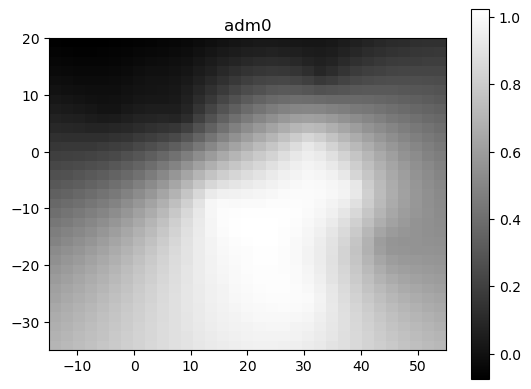

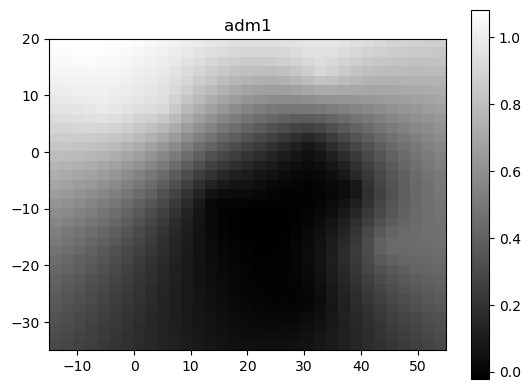

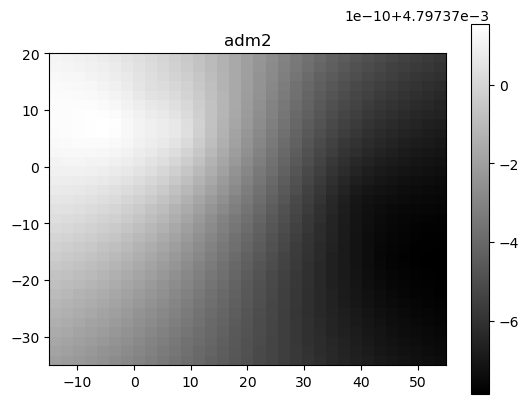

In [323]:
#from https://geostat-framework.readthedocs.io/_/downloads/pykrige/en/stable/pdf/

adm_cs={}
for adm_c in [0, 1, 2]:
    
    lon = cline_df["lon"]
    lat = cline_df["lat"]
    z = cline_df["adm{}".format(str(adm_c))]

    # Generate a regular grid with 60° longitude and 30° latitude steps:
    grid_lon = np.linspace(min_lon, max_lon, 33)
    grid_lat = np.linspace(min_lat, max_lat, 33)
    # Create ordinary kriging object:

    OK = OrdinaryKriging(
        lon,
        lat,
        z,
        variogram_model="linear",
        verbose=False,
        enable_plotting=False,
        coordinates_type="geographic",
        )

    # Execute on grid:
    adm_cs[adm_c], ss1 = OK.execute("grid", grid_lon, grid_lat)

    plt.imshow(adm_cs[adm_c], extent=[min_lon, max_lon
                                      , min_lat, max_lat], cmap='gray', origin="lower")
    plt.colorbar()
    plt.title("adm{}".format(str(adm_c)))
    plt.show()


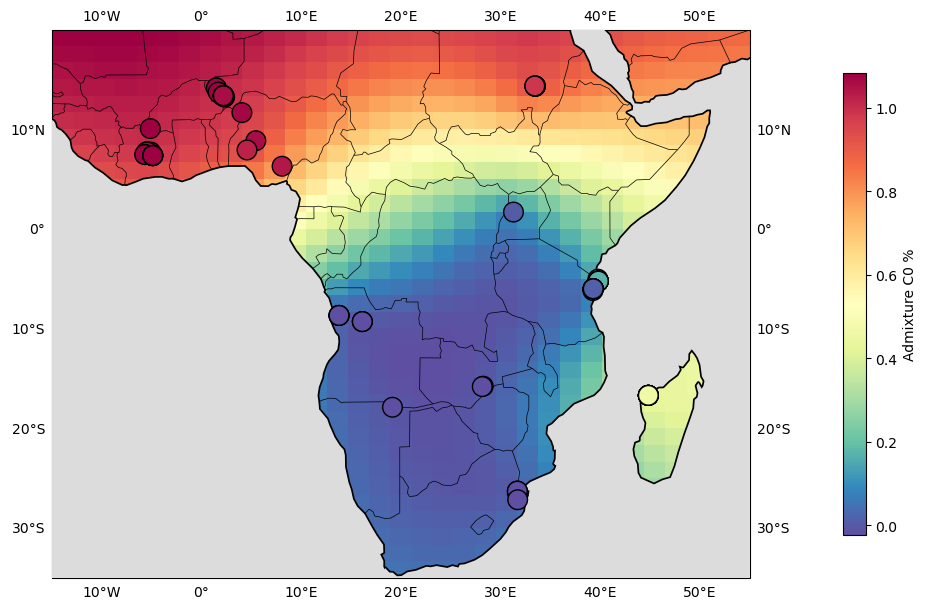

In [325]:
figure(figsize=(12, 12))

ax = plt.axes(projection=ccrs.PlateCarree())


plt.scatter(cline_df["lon"], cline_df["lat"],
         c=-cline_df["adm0"], cmap='Spectral_r', marker='o', s = 200, linewidth=1, edgecolor="black",
         transform=ccrs.Geodetic(), alpha=1, zorder=10
         )

plt.imshow(adm_cs[1], extent=(min_lon, max_lon, min_lat, max_lat), cmap='Spectral_r', origin="lower", zorder=1)
plt.colorbar(shrink=0.5, pad=0.1, label="Admixture C0 %")

ax.add_feature(cf.OCEAN, facecolor='gainsboro', zorder=4)

ax.coastlines(zorder=2, linewidth=2.5)
ax.add_feature(cf.BORDERS, edgecolor='black', zorder=4, linewidth=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, zorder=5, color="white", alpha=0)


plt.xlim([-15, 55])
plt.ylim([-35, 20])

# Save the plot by calling plt.savefig() BEFORE plt.show()
plt.savefig('kigring_map.png', dpi=300)
plt.savefig('kigring_map.svg')


plt.show()

In [135]:
sh_cline_df.country.unique()

array(['nigeria', 'cote_d_ivoire', 'niger', 'uganda', 'zanzibar',
       'angola', 'madagascar', 'namibia', 'sudan', 'swaziland', 'zambia'],
      dtype=object)

## distances between samples

In [25]:
sh_cline_df = cline_df.loc[((cline_df["kmeans_label"] == "sh_nw") | (cline_df["kmeans_label"] == "sh_se"))].dropna(subset=['lat', 'lon'])

kms = np.array([])
s1s = np.array([])
s2s = np.array([])

for s1 in tqdm(sh_cline_df["sample_name"]):
    s1_lat=cline_df.loc[cline_df["sample_name"] == s1]["lat"].values[0]
    s1_lon=cline_df.loc[cline_df["sample_name"] == s1]["lon"].values[0]
    
    for s2 in samples:
        s2_lat=cline_df.loc[cline_df["sample_name"] == s2]["lat"].values[0]
        s2_lon=cline_df.loc[cline_df["sample_name"] == s2]["lon"].values[0]
        
        kms=np.append(kms, haversine((s1_lat, s1_lon), (s2_lat, s2_lon)))
        s1s=np.append(s1s, s1)
        s2s=np.append(s2s, s2)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:19<00:00,  6.05it/s]


In [26]:
km_df = pd.DataFrame([s1s, s2s, kms]).T
km_df.columns=["s1", "s2", "km"]
km_df.sort_values("km", ascending=False, axis=0).dropna().head()

,s1,s2,km
16843,ssp_cdivoire_noumousso_94,sha_madag_belesalampy_80,6250.452986
16842,ssp_cdivoire_noumousso_94,sha_madag_belesalampy_78,6250.452986
6786,sha_madag_belesalampy_76,ssp_cdivoire_noumousso_94,6250.452986
6288,sha_madag_belesalampy_73,ssp_cdivoire_noumousso_94,6250.452986
6952,sha_madag_belesalampy_77,ssp_cdivoire_noumousso_94,6250.452986


reps from two most distant sites
 - sha_madag_belesalampy_80
 - ssp_cdivoire_noumousso_94

In [27]:
sh_cline_df.loc[sh_cline_df["sample_name"] == "sha_madag_belesalampy_80"]

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label
77,0.569843,0.00001,0.430147,sha_madag_belesalampy_80,madagascar,na,human,-16.6646,44.84056,sh_se


In [28]:
sh_cline_df.loc[sh_cline_df["sample_name"] == "ssp_cdivoire_noumousso_94"]

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label
146,0.012478,0.00001,0.987512,ssp_cdivoire_noumousso_94,cote_d_ivoire,na,snail,10.107108,-5.142159,sh_nw


In [127]:
sh_cline_df.sort_values(by=["lat", "lon"], ascending=[False, False]).head(n=10)

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,dist_from_ref
109,0.060901,0.00001,0.939089,sha_sudan_schoole_120,sudan,na,snail,14.386818,33.509815,sh_nw,4222.131919
111,0.099762,0.00001,0.900228,sha_sudan_schooli_129,sudan,na,snail,14.384994,33.445852,sh_nw,4215.23966
112,0.060267,0.00001,0.939723,sha_sudan_schooli_130,sudan,na,snail,14.384994,33.445852,sh_nw,4215.23966
110,0.137126,0.00001,0.862864,sha_sudan_schoolh_123,sudan,na,snail,14.373361,33.479290,sh_nw,4218.794875
105,0.098949,0.00001,0.901041,sha_sudan_canal4_125,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
106,0.102089,0.00001,0.897901,sha_sudan_canal4_126,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
107,0.056686,0.00001,0.943304,sha_sudan_canal4_127,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
108,0.067311,0.00001,0.932679,sha_sudan_canal4_132,sudan,na,snail,14.362360,33.487493,sh_nw,4219.636484
46,0.013577,0.00001,0.986413,sh_niger_SRR8284786,niger,na,human,14.187521,1.486310,sh_nw,851.340532
47,0.000010,0.00001,0.999980,sh_niger_SRR8284787,niger,na,human,14.187521,1.486310,sh_nw,851.340532


In [128]:
sh_cline_df.sort_values(by=["lat", "lon"], ascending=[False, False]).tail(n=10)

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,dist_from_ref
78,0.599515,0.00001,0.400475,sha_madag_belesalampy_81,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
79,0.577123,0.00001,0.422867,sha_madag_belesalampy_82,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
80,0.553578,0.00001,0.446412,sha_madag_belesalampy_83,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
81,0.617950,0.00001,0.382040,sha_madag_belesalampy_84,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
82,0.594832,0.00001,0.405158,sha_madag_belesalampy_87,madagascar,na,human,-16.664600,44.840560,sh_se,6250.452986
83,0.999980,0.00001,0.000010,sha_namib_mayenzere_134,namibia,na,human,-17.858400,19.159700,sh_se,4097.645177
119,0.999980,0.00001,0.000010,sha_swaz_njojane_188,swaziland,na,unk,-26.277583,31.699567,sh_se,5675.511528
120,0.999980,0.00001,0.000010,sha_swaz_njojane_190,swaziland,na,unk,-26.277583,31.699567,sh_se,5675.511528
121,0.999980,0.00001,0.000010,sha_swaz_njojane_191,swaziland,na,unk,-26.277583,31.699567,sh_se,5675.511528
122,0.999980,0.00001,0.000010,sha_swaz_qomintaba_185,swaziland,na,unk,-27.138917,31.728250,sh_se,5740.324876


In [30]:
sh_niger_SRR8284786, sha_swaz_qomintaba_185

,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label
109,0.060901,0.00001,0.939089,sha_sudan_schoole_120,sudan,na,snail,14.386818,33.509815,sh_nw
111,0.099762,0.00001,0.900228,sha_sudan_schooli_129,sudan,na,snail,14.384994,33.445852,sh_nw
112,0.060267,0.00001,0.939723,sha_sudan_schooli_130,sudan,na,snail,14.384994,33.445852,sh_nw
110,0.137126,0.00001,0.862864,sha_sudan_schoolh_123,sudan,na,snail,14.373361,33.479290,sh_nw
106,0.102089,0.00001,0.897901,sha_sudan_canal4_126,sudan,na,snail,14.362360,33.487493,sh_nw
...,...,...,...,...,...,...,...,...,...,...
83,0.999980,0.00001,0.000010,sha_namib_mayenzere_134,namibia,na,human,-17.858400,19.159700,sh_se
121,0.999980,0.00001,0.000010,sha_swaz_njojane_191,swaziland,na,unk,-26.277583,31.699567,sh_se
120,0.999980,0.00001,0.000010,sha_swaz_njojane_190,swaziland,na,unk,-26.277583,31.699567,sh_se
119,0.999980,0.00001,0.000010,sha_swaz_njojane_188,swaziland,na,unk,-26.277583,31.699567,sh_se


In [129]:
ref = "sh_niger_SRR8284786"

sh_cline_df["dist_from_ref"]="NA"

s1_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lat"].values[0]
s1_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lon"].values[0]

kms=[]

for index, row in tqdm(sh_cline_df.iterrows()):
    sample_id = row["sample_name"]
    s2_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lat"].values[0]
    s2_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lon"].values[0]

    km = haversine((s1_lat, s1_lon), (s2_lat, s2_lon))
    sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id, "dist_from_ref"] = km


sh_cline_df

121it [00:00, 1429.99it/s]


,adm0,adm1,adm2,sample_name,country,locale,host,lat,lon,kmeans_label,dist_from_ref
9,0.037610,0.221418,0.740972,Sh_NG_eb_6_2,nigeria,ebonyi,human,6.328611,8.082222,sh_nw,1132.961356
12,0.000010,0.015103,0.984887,Sh_NG_kb_2_1,nigeria,kebbi,human,11.710000,4.052222,sh_nw,391.404253
13,0.000010,0.055020,0.944970,Sh_NG_kw_1_10,nigeria,kwara,human,8.892222,5.451389,sh_nw,730.176092
14,0.018892,0.000010,0.981098,Sh_NG_os_1_4,nigeria,osun,human,7.963889,4.563889,sh_nw,769.141006
25,0.026561,0.012619,0.960820,sbo_cdivoire_raviart_108,cote_d_ivoire,na,snail,7.400372,-4.896099,sh_nw,1027.092362
...,...,...,...,...,...,...,...,...,...,...,...
161,0.011096,0.000010,0.988894,ssp_niger_libore_167,niger,na,snail,13.390080,2.197110,sh_nw,117.279903
162,0.009580,0.000010,0.990410,ssp_niger_libore_168,niger,na,snail,13.390080,2.197110,sh_nw,117.279903
163,0.012746,0.000010,0.987244,ssp_niger_libore_169,niger,na,snail,13.404170,2.188020,sh_nw,115.451739
164,0.000010,0.000010,0.999980,ssp_niger_libore_173,niger,na,snail,13.404170,2.188020,sh_nw,115.451739


121it [00:00, 1077.26it/s]


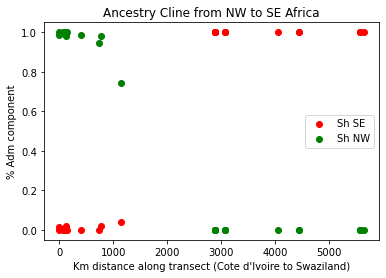

In [146]:
ref = "sh_niger_SRR8284786"

sh_cline_df["dist_from_ref"]="NA"

s1_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lat"].values[0]
s1_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lon"].values[0]

kms=[]

for index, row in tqdm(sh_cline_df.iterrows()):
    sample_id = row["sample_name"]
    s2_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lat"].values[0]
    s2_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lon"].values[0]

    km = haversine((s1_lat, s1_lon), (s2_lat, s2_lon))
    sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id, "dist_from_ref"] = km

    
tmp_df = sh_cline_df[sh_cline_df['country'].isin(["niger", "nigeria", "angola", "zambia", "namibia", "swaziland"])]
x=tmp_df["dist_from_ref"]
adm0_y=tmp_df["adm0"]
adm1_y=tmp_df["adm1"]
adm2_y=tmp_df["adm2"]

plt.scatter(x, adm0_y, c="red", label="Sh SE")
plt.scatter(x, adm2_y, c="green", label="Sh NW")
plt.xlabel("Km distance along transect (Cote d'Ivoire to Swaziland)")
plt.ylabel("% Adm component")
plt.title("Ancestry Cline from NW to SE Africa")
plt.legend()
plt.show()

tmp_df["sample_name"].to_csv("NW_SE_transect.samples", sep=",", index=None, header=None)

In [145]:
! head NW_SE_cline.samples

Sh_NG_eb_6_2
Sh_NG_kb_2_1
Sh_NG_kw_1_10
Sh_NG_os_1_4
sbo_niger_libore_154
sbo_niger_libore_155
sbo_niger_libore_160
sbo_niger_libore_162
sbo_niger_libore_163
sbo_niger_libore_164


121it [00:00, 1542.23it/s]


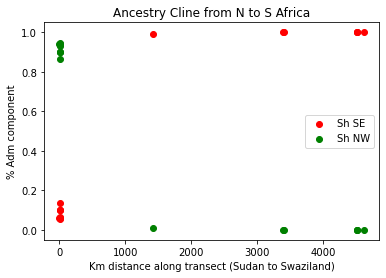

In [148]:
ref = "sha_sudan_schoole_120"

sh_cline_df["dist_from_ref"]="NA"

s1_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lat"].values[0]
s1_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == ref]["lon"].values[0]

kms=[]

for index, row in tqdm(sh_cline_df.iterrows()):
    sample_id = row["sample_name"]
    s2_lat=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lat"].values[0]
    s2_lon=sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id]["lon"].values[0]

    km = haversine((s1_lat, s1_lon), (s2_lat, s2_lon))
    sh_cline_df.loc[sh_cline_df["sample_name"] == sample_id, "dist_from_ref"] = km
    
tmp_df = sh_cline_df[sh_cline_df['country'].isin(["sudan", "uganda", "zambia", "swaziland"])]
x=tmp_df["dist_from_ref"]
adm0_y=tmp_df["adm0"]
adm1_y=tmp_df["adm1"]
adm2_y=tmp_df["adm2"]

plt.scatter(x, adm0_y, c="red", label="Sh SE")
plt.scatter(x, adm2_y, c="green", label="Sh NW")
plt.xlabel("Km distance along transect (Sudan to Swaziland)")
plt.ylabel("% Adm component")
plt.title("Ancestry Cline from N to S Africa")
plt.legend()
plt.show()

tmp_df["sample_name"].to_csv("N_S_transect.samples", sep=",", index=None, header=None)

## clines

In [150]:
#read in the vcf file
filtered_callset=allel.read_vcf('../filter_genotypes/maf05.vcf')

#get relevant info
gt      = allel.GenotypeArray(filtered_callset['calldata/GT'])
chroms  = filtered_callset["variants/CHROM"]
samples = filtered_callset["samples"]
poss    = filtered_callset["variants/POS"]
var_ids = filtered_callset["variants/ID"]

uniq_chroms=np.unique(chroms)

In [151]:
#now get species/country idexs
sp_country_idxs = defaultdict(lambda: {})
sp_country_acs  = defaultdict(lambda: {})

for sp in tqdm(["s_bovis", "s_haematobium"]):
    sp_countries = pca_df.loc[ pca_df["pca_species"] == sp]["country"].astype(str).unique()
    
    for country in sp_countries:
        sp_country_idxs[sp][country] = list(pca_df.loc[ (pca_df["pca_species"] == sp) &  (pca_df["country"] == country)].index)
        #if len(sp_country_idxs[sp][country]) > 1:

        #get allele counts for each species
        sp_country_acs[sp][country] = gt.count_alleles(subpop=sp_country_idxs[sp][country])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [01:00<00:00, 30.32s/it]


Get high fst snps along a transect

In [152]:
s1=sp_country_idxs["s_haematobium"]["niger"]
s2=sp_country_idxs["s_haematobium"]["swaziland"]

c1, c2, c3 = allel.weir_cockerham_fst(gt, [s1, s2])

fsts=c1/(c1+c2+c3)

/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:184: RuntimeWarning: invalid value encountered in true_divide
  p = ac / an[:, np.newaxis, :]
/master/nplatt/anaconda3/envs/popstructure/lib/python3.9/site-packages/allel/stats/fst.py:225: RuntimeWarning: divide by zero encountered in true_divide
  a = ((n_bar / n_C) *
/tmp/ipykernel_35651/3381524001.py:6: RuntimeWarning: invalid value encountered in true_divide
  fsts=c1/(c1+c2+c3)


In [153]:
fsts = (np.sum(c1, axis=1) / (np.sum(c1, axis=1) + np.sum(c2, axis=1) + np.sum(c3, axis=1)))

/tmp/ipykernel_35651/1691969255.py:1: RuntimeWarning: invalid value encountered in true_divide
  fsts = (np.sum(c1, axis=1) / (np.sum(c1, axis=1) + np.sum(c2, axis=1) + np.sum(c3, axis=1)))


In [154]:
fst_mask=(fsts >0.5)

high_fst_snvs=[]
for chrom, pos in zip(chroms[fst_mask], poss[fst_mask]):
    high_fst_snvs.append("{}:{}".format(chrom, pos))
    
    
pd.Series(high_fst_snvs).to_csv("high_fst_snvs.list", sep=",", index=None, header=None)

In [155]:
! head high_fst_snvs.list

HiC_scaffold_1:155076
HiC_scaffold_1:292678
HiC_scaffold_1:293192
HiC_scaffold_1:293406
HiC_scaffold_1:296530
HiC_scaffold_1:296533
HiC_scaffold_1:296547
HiC_scaffold_1:311260
HiC_scaffold_1:311300
HiC_scaffold_1:332747


In [ ]:
%%bash 

vcftools \
    --vcf ../filter_genotypes/maf05.vcf \
    --snps high_fst_snvs.list \
    --keep NW_SE_transect.samples \
    --recode \
    --recode-INFO-all \
    --stdout \
    >high_fst_snvs_NW_SE.vcf

In [ ]:
%%bash 

plink \
    --vcf high_fst_snvs_NW_SE.vcf \
    --allow-extra-chr \
    --double-id \
    --indep-pairwise 25 5 0.20 \
    --out high_fst_snvs_NW_SE_ld

vcftools \
    --vcf high_fst_snvs_NW_SE.vcf \
    --exclude maf05_ld_filtered.prune.out \
    --recode \
    --recode-INFO-all \
    --stdout \
    >high_fst_snvs_NW_SE_ld.vcf

vcftools \
    --vcf high_fst_snvs_NW_SE.vcf \
    --thin 10000 \
    --recode \
    --recode-INFO-all \
    --stdout \
    >high_fst_snvs_NW_SE_ld_thinned.vcf

In [ ]:
populations  \
    -V 'high_fst_snvs.vcf' \
    -M 'mypopmap.tsv' \
    --hzar \


In [158]:
%%R
library(hzar)
d<-read.delim("hzar/high_fst_snvs.p.hzar.csv", sep=",")
    

UsageError: Cell magic `%%R` not found.


In [391]:
%%R
library(hzar)

UsageError: Cell magic `%%R` not found.


In [392]:
#read in the vcf file
cline_callset=allel.read_vcf('high_fst_snvs.vcf')

#get relevant info
cgt      = allel.GenotypeArray(cline_callset['calldata/GT'])
cchroms  = cline_callset["variants/CHROM"]
csamples = cline_callset["samples"]
cposs    = cline_callset["variants/POS"]
cvar_ids = cline_callset["variants/ID"]

In [410]:
idx = int(pca_df.loc[pca_df["sample_name"] == sample].index[0])

9

In [428]:
list(csamples).index("sh_tzpem_SRR8284797")

37

In [451]:
#now get species/country idexs
country_idxs = defaultdict(lambda: [])
country_acs  = defaultdict(lambda: [])
rs = defaultdict(lambda: [])
for sample in tqdm(csamples):
    country = pca_df.loc[ pca_df["sample_name"] == sample, "country"].values[0]
    idx = list(csamples).index(sample)
    
    country_idxs[country].append(idx)
    
for country in tqdm(country_idxs.keys()):

    num_samples = len(country_idxs[country])
    if num_samples > 4:
        idxs = country_idxs[country]
        
        #get allele counts for each country
        country_acs[country] = cgt.count_alleles(subpop=idxs)

        rs[country] = country_acs[country].to_frequencies()[:,0]
    
# countries

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 90.71it/s]


In [453]:
country_acs.keys()

dict_keys(['nigeria', 'cote_d_ivoire', 'niger', 'zanzibar', 'angola', 'madagascar', 'sudan', 'swaziland'])

In [454]:
acs_df=pd.DataFrame([rs["nigeria"], rs['cote_d_ivoire'], 
                     rs['niger'],   rs['zanzibar'],  rs['angola'], 
                     rs['madagascar'], rs['sudan'], rs['swaziland'] ])
                    
    
    
acs_df=acs_df.T
acs_df.columns=['nigeria', 'cote_d_ivoire', 'niger', 'zanzibar', 'angola', 'madagascar', 'sudan', 'swaziland' ]    
    
acs_df
# plt.plot(rs["nigeria"], rs["swaziland"]])
# plt.show

,nigeria,cote_d_ivoire,niger,zanzibar,angola,madagascar,sudan,swaziland
0,0.916667,0.921053,0.965517,1.000000,1.000000,1.000000,0.5,1.000000
1,1.000000,1.000000,1.000000,0.250000,0.300000,0.250000,1.0,0.285714
2,0.833333,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0.125000
3,1.000000,1.000000,1.000000,0.815789,0.600000,0.772727,1.0,0.500000
4,0.928571,0.958333,1.000000,0.022727,0.071429,0.000000,1.0,0.055556
...,...,...,...,...,...,...,...,...
77736,1.000000,1.000000,1.000000,0.500000,0.500000,0.714286,1.0,0.545455
77737,1.000000,1.000000,1.000000,0.552632,0.562500,0.666667,1.0,0.416667
77738,1.000000,1.000000,1.000000,0.473684,0.500000,0.500000,1.0,0.416667
77739,1.000000,1.000000,1.000000,0.473684,0.500000,0.583333,1.0,0.416667


In [465]:
delta_p = abs(acs_df["nigeria"] - acs_df["swaziland"])
delta_df = acs_df[(delta_p>0.5)]



In [466]:
delta_df

,nigeria,cote_d_ivoire,niger,zanzibar,angola,madagascar,sudan,swaziland
1,1.000000,1.000000,1.000000,0.250000,0.300000,0.250000,1.00,0.285714
2,0.833333,1.000000,1.000000,0.000000,0.000000,0.000000,1.00,0.125000
4,0.928571,0.958333,1.000000,0.022727,0.071429,0.000000,1.00,0.055556
5,0.928571,0.958333,1.000000,0.022727,0.071429,0.000000,1.00,0.055556
6,0.928571,0.958333,1.000000,0.022727,0.071429,0.000000,1.00,0.055556
...,...,...,...,...,...,...,...,...
77729,0.000000,0.000000,0.016129,0.027778,0.000000,0.000000,0.25,0.750000
77737,1.000000,1.000000,1.000000,0.552632,0.562500,0.666667,1.00,0.416667
77738,1.000000,1.000000,1.000000,0.473684,0.500000,0.500000,1.00,0.416667
77739,1.000000,1.000000,1.000000,0.473684,0.500000,0.583333,1.00,0.416667
